# Multiomics AI analysis

## Overview
This notebook implements:
- **Phase 1**: Data loading, preprocessing, and quality control
- **Phase 2**: Single-omics analysis
  - Differential Expression Analysis (DESeq2 approach in Python)
  - Genetic Association Analysis (eQTL mapping)

## Dataset
- 300 samples (200 ASD cases, 100 controls)
- 50 SNPs from WGS data
- 20 genes from bulk RNA-seq (2 batches of 10 genes each)
- Clinical and demographic covariates

---
## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All libraries imported successfully
NumPy version: 1.26.4
Pandas version: 2.2.3


---
# PHASE 1: DATA PREPROCESSING & QUALITY CONTROL

## 1.1 Load All Dataset Files

In [2]:
# Define data directory
DATA_DIR = "../data/ASD_dataset/"

files_generated = []

print("Loading dataset files...\n")

# Load covariates and clinical data
covariates = pd.read_csv(f"{DATA_DIR}ASD_covariates.csv")
print(f"✓ Loaded covariates: {covariates.shape[0]} samples, {covariates.shape[1]} variables")

# Load genotype data
genotypes = pd.read_csv(f"{DATA_DIR}ASD_genotypes.csv")
print(f"✓ Loaded genotypes: {genotypes.shape[0]} samples, {genotypes.shape[1]-1} SNPs")

# Load expression data (two batches)
expression = pd.read_csv(f"{DATA_DIR}ASD_expression1.csv")
print(f"✓ Loaded expression: {expression.shape[0]} samples, {expression.shape[1]-1} genes")

# Load annotations
gene_annotations = pd.read_csv(f"{DATA_DIR}ASD_gene_annotations.csv")
snp_annotations = pd.read_csv(f"{DATA_DIR}ASD_snp_annotations.csv")
print(f"✓ Loaded gene annotations: {len(gene_annotations)} genes annotated")
print(f"✓ Loaded SNP annotations: {len(snp_annotations)} SNPs annotated")

print("\n" + "="*80)
print("ALL DATA LOADED SUCCESSFULLY")
print("="*80)


Loading dataset files...

✓ Loaded covariates: 300 samples, 29 variables
✓ Loaded genotypes: 300 samples, 50 SNPs
✓ Loaded expression: 300 samples, 10 genes
✓ Loaded gene annotations: 12 genes annotated
✓ Loaded SNP annotations: 40 SNPs annotated

ALL DATA LOADED SUCCESSFULLY


## 1.2 Data Quality Assessment

In [3]:
print("QUALITY CONTROL CHECKS\n")
print("="*80)

# Check 1: Sample consistency across datasets
print("\n1. Sample ID Consistency Check:")
samples_cov = set(covariates['sample'])
samples_geno = set(genotypes['sample'])
samples_expr = set(expression['sample'])

all_samples_match = (samples_cov == samples_geno == samples_expr)
print(f"   All datasets have matching samples: {all_samples_match}")
print(f"   Total unique samples: {len(samples_cov)}")

# Check 2: Missing values
print("\n2. Missing Value Check:")
print(f"   Covariates missing: {covariates.isnull().sum().sum()}")
print(f"   Genotypes missing: {genotypes.isnull().sum().sum()}")
print(f"   Expression missing: {expression.isnull().sum().sum()}")

# Check 3: Data type verification
print("\n3. Data Type Verification:")
print(f"   Genotypes are numeric (0/1/2): {genotypes.iloc[:, 1:].isin([0, 1, 2]).all().all()}")
print(f"   Expression values are float: {expression.iloc[:, 1:].dtypes.apply(lambda x: x.kind == 'f').all()}")

# Check 4: Clinical variable distributions
print("\n4. Clinical Variables Summary:")
print(f"   ASD cases: {covariates['ASD'].sum()} ({100*covariates['ASD'].mean():.1f}%)")
print(f"   Controls: {(1-covariates['ASD']).sum()} ({100*(1-covariates['ASD'].mean()):.1f}%)")
print(f"   Sex ratio (% Male): {100*covariates['Sex'].mean():.1f}%")
print(f"   Age range: {covariates['Age'].min():.1f} - {covariates['Age'].max():.1f} years")
print(f"   IQ range: {covariates['IQ'].min():.1f} - {covariates['IQ'].max():.1f}")

print("\n" + "="*80)
print("QUALITY CONTROL PASSED ✓")
print("="*80)

QUALITY CONTROL CHECKS


1. Sample ID Consistency Check:
   All datasets have matching samples: True
   Total unique samples: 300

2. Missing Value Check:
   Covariates missing: 0
   Genotypes missing: 0
   Expression missing: 0

3. Data Type Verification:
   Genotypes are numeric (0/1/2): True
   Expression values are float: False

4. Clinical Variables Summary:
   ASD cases: 200 (66.7%)
   Controls: 100 (33.3%)
   Sex ratio (% Male): 67.7%
   Age range: 3.0 - 18.0 years
   IQ range: 45.0 - 141.0

QUALITY CONTROL PASSED ✓


## 1.3 Merge Expression Data and Prepare Combined Dataset

In [4]:
# Create master dataset with sample IDs aligned
# We'll keep separate DataFrames for different omics layers but ensure sample order is consistent

# Set sample as index for easier merging
covariates_indexed = covariates.set_index('sample')
genotypes_indexed = genotypes.set_index('sample')
expression_indexed = expression.set_index('sample')

# Verify all indices match
assert (covariates_indexed.index.equals(genotypes_indexed.index)) and (genotypes_indexed.index.equals(expression_indexed.index)), \
    "Sample indices do not match across datasets!"

print("✓ All datasets aligned by sample ID")
print(f"  - Covariates: {covariates_indexed.shape}")
print(f"  - Genotypes: {genotypes_indexed.shape}")
print(f"  - Expression: {expression_indexed.shape}")

✓ All datasets aligned by sample ID
  - Covariates: (300, 28)
  - Genotypes: (300, 50)
  - Expression: (300, 10)


## 1.4 Exploratory Data Analysis - Sample Characteristics

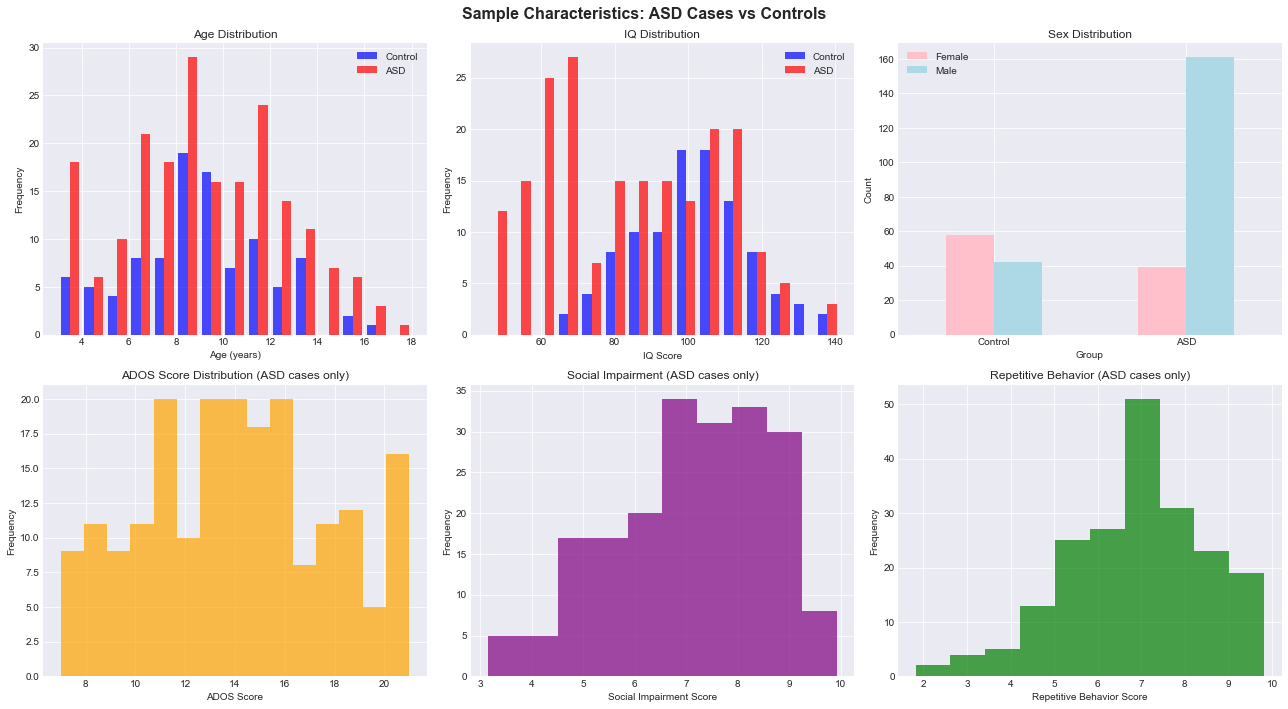

✓ Sample characteristics visualized and saved


In [5]:
# Create visualization of sample characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Sample Characteristics: ASD Cases vs Controls', fontsize=16, fontweight='bold')

# 1. Age distribution
asd_samples = covariates_indexed[covariates_indexed['ASD'] == 1]
ctrl_samples = covariates_indexed[covariates_indexed['ASD'] == 0]

axes[0, 0].hist([ctrl_samples['Age'], asd_samples['Age']], 
                bins=15, label=['Control', 'ASD'], alpha=0.7, color=['blue', 'red'])
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].legend()

# 2. IQ distribution
axes[0, 1].hist([ctrl_samples['IQ'], asd_samples['IQ']], 
                bins=15, label=['Control', 'ASD'], alpha=0.7, color=['blue', 'red'])
axes[0, 1].set_xlabel('IQ Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('IQ Distribution')
axes[0, 1].legend()

# 3. Sex distribution
sex_counts = covariates_indexed.groupby(['ASD', 'Sex']).size().unstack()
sex_counts.plot(kind='bar', ax=axes[0, 2], color=['pink', 'lightblue'])
axes[0, 2].set_xlabel('Group')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Sex Distribution')
axes[0, 2].set_xticklabels(['Control', 'ASD'], rotation=0)
axes[0, 2].legend(['Female', 'Male'])

# 4. ADOS Score (ASD only)
axes[1, 0].hist(asd_samples['ADOS_Score'], bins=15, color='orange', alpha=0.7)
axes[1, 0].set_xlabel('ADOS Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('ADOS Score Distribution (ASD cases only)')

# 5. Social Impairment
axes[1, 1].hist(asd_samples['Social_Impairment'], bins=10, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Social Impairment Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Social Impairment (ASD cases only)')

# 6. Repetitive Behavior
axes[1, 2].hist(asd_samples['Repetitive_Behavior'], bins=10, color='green', alpha=0.7)
axes[1, 2].set_xlabel('Repetitive Behavior Score')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Repetitive Behavior (ASD cases only)')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase1_QC_sample_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Sample characteristics visualized and saved")

## 1.5 Statistical Tests for Covariate Balance

In [6]:
print("Testing for Covariate Balance between ASD and Control Groups\n")
print("="*80)

# Age comparison (t-test)
age_stat, age_pval = stats.ttest_ind(ctrl_samples['Age'], asd_samples['Age'])
print(f"Age:")
print(f"  Control: {ctrl_samples['Age'].mean():.2f} ± {ctrl_samples['Age'].std():.2f}")
print(f"  ASD:     {asd_samples['Age'].mean():.2f} ± {asd_samples['Age'].std():.2f}")
print(f"  p-value: {age_pval:.4f}\n")

# Sex comparison (Chi-square)
sex_contingency = pd.crosstab(covariates_indexed['ASD'], covariates_indexed['Sex'])
chi2, sex_pval, dof, expected = chi2_contingency(sex_contingency)
print(f"Sex:")
print(f"  Control: {100*ctrl_samples['Sex'].mean():.1f}% Male")
print(f"  ASD:     {100*asd_samples['Sex'].mean():.1f}% Male")
print(f"  p-value: {sex_pval:.4f} (Chi-square test)\n")

# IQ comparison (t-test)
iq_stat, iq_pval = stats.ttest_ind(ctrl_samples['IQ'], asd_samples['IQ'])
print(f"IQ:")
print(f"  Control: {ctrl_samples['IQ'].mean():.2f} ± {ctrl_samples['IQ'].std():.2f}")
print(f"  ASD:     {asd_samples['IQ'].mean():.2f} ± {asd_samples['IQ'].std():.2f}")
print(f"  p-value: {iq_pval:.4e}\n")

print("="*80)
print("NOTE: Significant differences in IQ and Sex are expected for ASD")
print("      These will be included as covariates in downstream analyses")
print("="*80)

Testing for Covariate Balance between ASD and Control Groups

Age:
  Control: 8.99 ± 2.95
  ASD:     9.16 ± 3.42
  p-value: 0.6698

Sex:
  Control: 42.0% Male
  ASD:     80.5% Male
  p-value: 0.0000 (Chi-square test)

IQ:
  Control: 101.64 ± 15.33
  ASD:     83.95 ± 23.08
  p-value: 2.5053e-11

NOTE: Significant differences in IQ and Sex are expected for ASD
      These will be included as covariates in downstream analyses


## 1.6 Expression Data Quality Control

Expression Data Quality Metrics

Expression value summary statistics:
         gene_1      gene_2      gene_3       gene_4     gene_5     gene_6  \
mean   7.820000  174.180000  275.036667  1052.573333  31.810000   1.703333   
std    5.640359   79.560252  130.051477   537.601397  14.524822   2.302098   
min    0.000000   29.000000   67.000000   279.000000   4.000000   0.000000   
max   41.000000  430.000000  735.000000  2927.000000  88.000000  12.000000   

          gene_7      gene_8      gene_9       gene_10  
mean  336.086667  304.330000   95.496667  33088.390000  
std   190.215999  128.371304   45.261596  17294.027881  
min    91.000000   49.000000   19.000000   6645.000000  
max   973.000000  776.000000  267.000000  96848.000000  


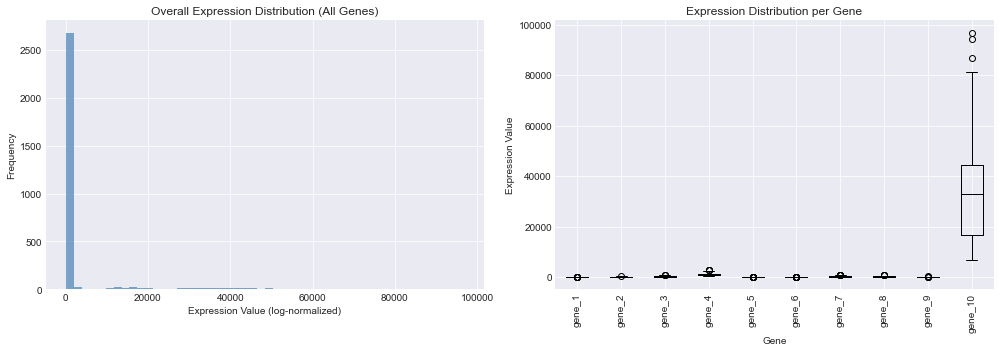


✓ Expression QC complete


In [7]:
# Check expression value distributions
print("Expression Data Quality Metrics\n")

# Summary statistics
expr_stats = expression_indexed.describe()
print("Expression value summary statistics:")
print(expr_stats.loc[['mean', 'std', 'min', 'max']])

# Plot expression distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
expression_indexed.values.flatten().reshape(-1, 1)
axes[0].hist(expression_indexed.values.flatten(), bins=50, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Expression Value (log-normalized)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Overall Expression Distribution (All Genes)')

# Per-gene boxplot (first 20 genes)
expression_indexed.iloc[:, :20].boxplot(ax=axes[1], rot=90, color='black')
axes[1].set_xlabel('Gene')
axes[1].set_ylabel('Expression Value')
axes[1].set_title('Expression Distribution per Gene')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase1_QC_expression_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Expression QC complete")

## 1.7 Genotype Data Quality Control

Genotype Data Quality Metrics

Number of SNPs: 50
Mean allele frequency: 0.241
Min allele frequency: 0.007
Max allele frequency: 0.500

Monomorphic SNPs (no variation): 0


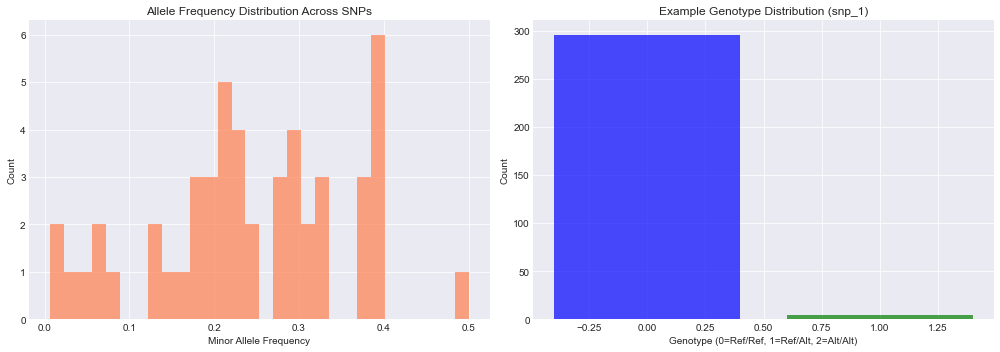


✓ Genotype QC complete


In [8]:
print("Genotype Data Quality Metrics\n")

# Calculate allele frequencies
allele_freqs = genotypes_indexed.mean() / 2  # Convert dosage to allele frequency
maf = allele_freqs.clip(upper=0.5)

print(f"Number of SNPs: {len(allele_freqs)}")
print(f"Mean allele frequency: {maf.mean():.3f}")
print(f"Min allele frequency: {maf.min():.3f}")
print(f"Max allele frequency: {maf.max():.3f}\n")

# Check for monomorphic SNPs (should have variation)
monomorphic_snps = genotypes_indexed.columns[genotypes_indexed.std() == 0]
print(f"Monomorphic SNPs (no variation): {len(monomorphic_snps)}")

# Plot allele frequency distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(maf, bins=30, alpha=0.7, color='coral')
axes[0].set_xlabel('Minor Allele Frequency')
axes[0].set_ylabel('Count')
axes[0].set_title('Allele Frequency Distribution Across SNPs')

# Genotype distribution for first SNP as example
genotype_counts = genotypes_indexed.iloc[:, 0].value_counts().sort_index()
# Handle cases where not all genotypes are present
genotype_labels = genotype_counts.index.tolist()
genotype_values = genotype_counts.values.tolist()
colors_map = {0: 'blue', 1: 'green', 2: 'red'}
bar_colors = [colors_map[g] for g in genotype_labels]
axes[1].bar(genotype_labels, genotype_values, color=bar_colors, alpha=0.7)
axes[1].set_xlabel('Genotype (0=Ref/Ref, 1=Ref/Alt, 2=Alt/Alt)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Example Genotype Distribution ({genotypes_indexed.columns[0]})')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase1_QC_genotype_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Genotype QC complete")

## 1.8 Principal Component Analysis for Population Structure

Performing PCA on genotype data to check for population structure...



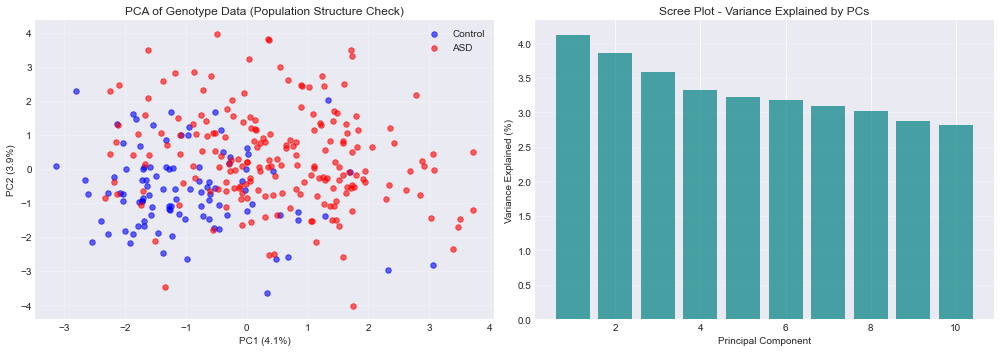


Variance explained by first 5 PCs: 18.12%

✓ PCA analysis complete
  Note: First 3 PCs will be used as covariates in association analyses


In [9]:
print("Performing PCA on genotype data to check for population structure...\n")

# Standardize genotype data
scaler = StandardScaler()
genotypes_scaled = scaler.fit_transform(genotypes_indexed)

# Perform PCA
pca = PCA(n_components=10)
pcs = pca.fit_transform(genotypes_scaled)

# Create DataFrame with PCs
pc_df = pd.DataFrame(
    pcs[:, :5],
    index=genotypes_indexed.index,
    columns=[f'PC{i+1}' for i in range(5)]
)

# Add ASD status for visualization
pc_df['ASD'] = covariates_indexed['ASD']

# Plot first two PCs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1 vs PC2 colored by ASD status
for status, label, color in [(0, 'Control', 'blue'), (1, 'ASD', 'red')]:
    mask = pc_df['ASD'] == status
    axes[0].scatter(pc_df.loc[mask, 'PC1'], pc_df.loc[mask, 'PC2'], 
                    label=label, alpha=0.6, s=30, color=color)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('PCA of Genotype Data (Population Structure Check)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scree plot
axes[1].bar(range(1, 11), pca.explained_variance_ratio_[:10] * 100, alpha=0.7, color='teal')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained (%)')
axes[1].set_title('Scree Plot - Variance Explained by PCs')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase1_QC_genotype_PCA.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVariance explained by first 5 PCs: {pca.explained_variance_ratio_[:5].sum()*100:.2f}%")
print("\n✓ PCA analysis complete")
print("  Note: First 3 PCs will be used as covariates in association analyses")

# Save PCs for later use
pc_df_save = pc_df.drop(columns=['ASD'])
genotype_pcs = pc_df_save.copy()  # Store for later use

---
# PHASE 2: SINGLE-OMICS ANALYSIS

## 2.1 Differential Expression Analysis

In [106]:
!cd .. && python scripts/DESeq2_docker.py
de_results_df = pd.read_csv('../data/ASD_dataset/Phase2_DESeq2_results.csv')

Preparing data for DESeq2 Analysis

✓ Loaded expression data: (300, 10)
✓ Loaded covariates data: (300, 28)
✓ Data prepared for DESeq2
  Count matrix shape: (300, 10)
  Sample metadata shape: (300, 4)
✓ R script created

Running DESeq2 using Docker container...
(This may take a few minutes on first run while pulling the image)

Running command: docker run --rm -v /Users/vladimirk/repositories/multiomics/data/ASD_dataset:/data getwilds/deseq2 Rscript /data/run_deseq2.R

Count data range: 0 to 96848
Mean count: 3536.7
Any NA values: FALSE

DESeq2 Analysis Complete
Total genes tested: 10
Significant DEGs (padj < 0.05): 9
Upregulated in ASD: 6
Downregulated in ASD: 3

Top 10 Differentially Expressed Genes:
           Gene log2FoldChange        pvalue          padj Significant
gene_3   gene_3    1.498824999  0.000000e+00  0.000000e+00        TRUE
gene_7   gene_7   -0.924343517  0.000000e+00  0.000000e+00        TRUE
gene_10 gene_10    1.881252627  0.000000e+00  0.000000e+00        TRUE
gene

## 2.1.1 Volcano Plot

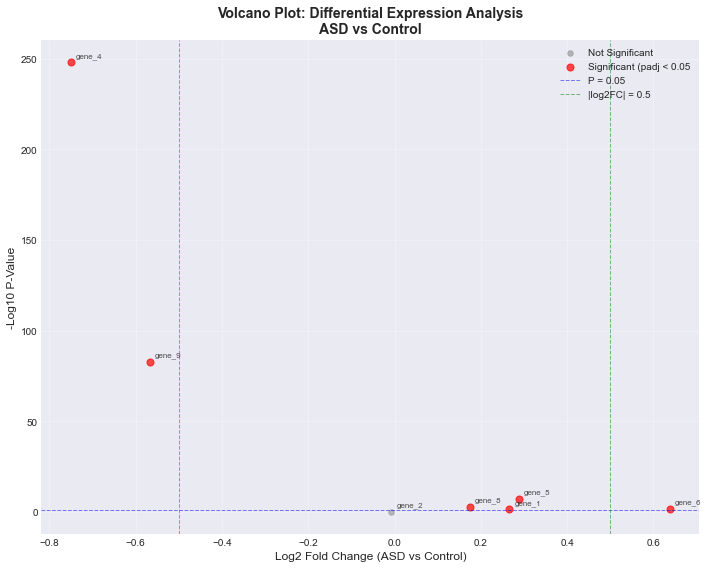

✓ Volcano plot saved


In [70]:
# Create volcano plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all genes
significant = de_results_df['Significant']
ax.scatter(de_results_df.loc[~significant, 'log2FoldChange'], 
           -np.log10(de_results_df.loc[~significant, 'padj']),
           c='gray', alpha=0.5, s=30, label='Not Significant')

# Plot significant genes
ax.scatter(de_results_df.loc[significant, 'log2FoldChange'], 
           -np.log10(de_results_df.loc[significant, 'padj']),
           c='red', alpha=0.7, s=50, label='Significant (padj < 0.05')

# Add gene labels for top significant genes
top_genes = de_results_df.nsmallest(10, 'padj')
for _, row in top_genes.iterrows():
    ax.annotate(row['Gene'], 
                xy=(row['log2FoldChange'], -np.log10(row['padj'])),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

# Add threshold lines
ax.axhline(-np.log10(0.05), color='blue', linestyle='--', alpha=0.5, linewidth=1, label='P = 0.05')
ax.axvline(-0.5, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(0.5, color='green', linestyle='--', alpha=0.5, linewidth=1, label='|log2FC| = 0.5')

ax.set_xlabel('Log2 Fold Change (ASD vs Control)', fontsize=12)
ax.set_ylabel('-Log10 P-Value', fontsize=12)
ax.set_title('Volcano Plot: Differential Expression Analysis\nASD vs Control', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase2_DE_volcano_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Volcano plot saved")

## 2.1.2 Heatmap of Top Differentially Expressed Genes

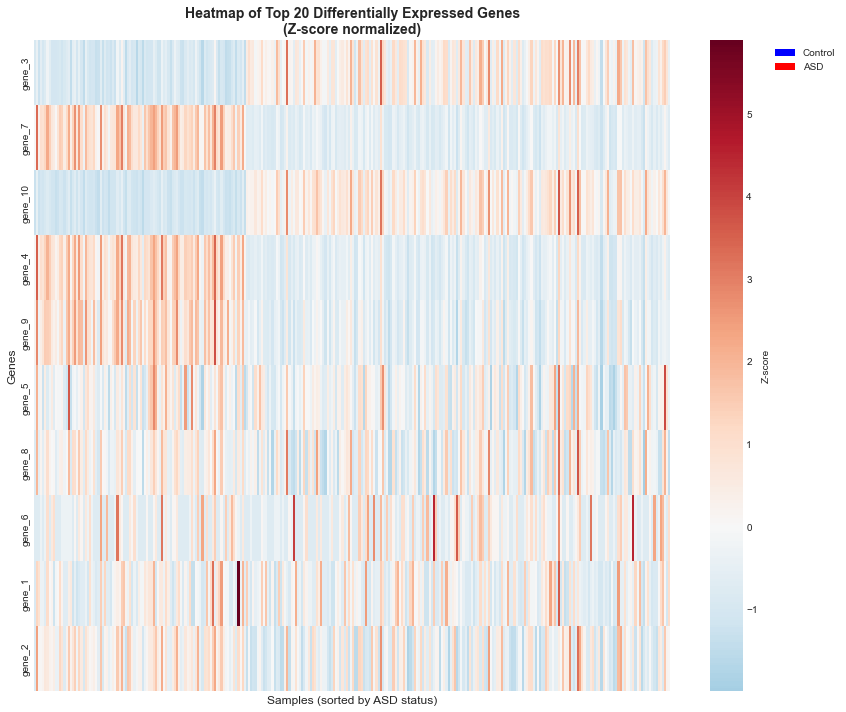

✓ Heatmap saved


In [71]:
# Select top 20 DEGs by p-value
top_degs = de_results_df.nsmallest(20, 'padj')['Gene'].tolist()

# Get expression data for these genes
expr_top = expression_indexed[top_degs]

# Add ASD status for sorting
expr_top_with_status = expr_top.copy()
expr_top_with_status['ASD'] = covariates_indexed['ASD']

# Sort by ASD status
expr_top_sorted = expr_top_with_status.sort_values('ASD').drop(columns=['ASD'])

# Z-score normalization for visualization
from scipy.stats import zscore
expr_top_zscore = expr_top_sorted.apply(zscore, axis=0)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Create annotation colors for ASD status
asd_status = covariates_indexed.loc[expr_top_sorted.index, 'ASD']
row_colors = ['red' if x == 1 else 'blue' for x in asd_status]

# Plot heatmap
sns.heatmap(expr_top_zscore.T, 
            cmap='RdBu_r', 
            center=0,
            cbar_kws={'label': 'Z-score'},
            yticklabels=True,
            xticklabels=False,
            ax=ax)

ax.set_xlabel('Samples (sorted by ASD status)', fontsize=12)
ax.set_ylabel('Genes', fontsize=12)
ax.set_title('Heatmap of Top 20 Differentially Expressed Genes\n(Z-score normalized)', 
             fontsize=14, fontweight='bold')

# Add color bar for sample groups
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Control'),
                   Patch(facecolor='red', label='ASD')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase2_DE_heatmap_top20.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Heatmap saved")

## 2.2 Genetic Association Analysis

### 2.2.1 SNP-ASD Association Testing

In [72]:
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression

print("Performing SNP-ASD Association Analysis\n")
print("="*80)

# Prepare results storage
gwas_results = []

# Get ASD status
asd_status = covariates_indexed['ASD'].values

# For each SNP, test association with ASD
for snp in genotypes_indexed.columns:
    genotype = genotypes_indexed[snp].values
    
    # Calculate allele frequencies in cases and controls
    freq_asd = genotype[asd_status == 1].mean() / 2
    freq_ctrl = genotype[asd_status == 0].mean() / 2
    
    # Logistic regression: ASD ~ genotype + age + sex + PC1 + PC2 + PC3
    # Prepare covariates
    X = pd.DataFrame({
        'genotype': genotype,
        'age': covariates_indexed['Age'].values,
        'sex': covariates_indexed['Sex'].values,
        'PC1': genotype_pcs['PC1'].values,
        'PC2': genotype_pcs['PC2'].values,
        'PC3': genotype_pcs['PC3'].values
    })
    
    y = asd_status
    
    # Fit logistic regression
    try:
        lr = LogisticRegression(max_iter=1000, solver='lbfgs')
        lr.fit(X, y)
        
        # Get coefficient and odds ratio for genotype
        beta = lr.coef_[0][0]
        odds_ratio = np.exp(beta)
        
        # Calculate p-value using likelihood ratio test approximation
        # Simplified: use chi-square test for genotype counts
        contingency_table = pd.crosstab(genotype, asd_status)
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
        
        gwas_results.append({
            'SNP': snp,
            'Freq_ASD': freq_asd,
            'Freq_Control': freq_ctrl,
            'Beta': beta,
            'OR': odds_ratio,
            'Chi2': chi2,
            'P_Value': pval
        })
    except:
        # If regression fails (e.g., perfect separation), use chi-square only
        contingency_table = pd.crosstab(genotype, asd_status)
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
        
        gwas_results.append({
            'SNP': snp,
            'Freq_ASD': freq_asd,
            'Freq_Control': freq_ctrl,
            'Beta': np.nan,
            'OR': np.nan,
            'Chi2': chi2,
            'P_Value': pval
        })

# Convert to DataFrame
gwas_results_df = pd.DataFrame(gwas_results)

# Apply FDR correction
gwas_results_df['FDR'] = multipletests(gwas_results_df['P_Value'], method='fdr_bh')[1]

# Sort by p-value
gwas_results_df = gwas_results_df.sort_values('P_Value')

# Define significance
gwas_results_df['Significant'] = gwas_results_df['FDR'] < 0.05

print(f"GWAS Analysis Complete")
print(f"  Total SNPs tested: {len(gwas_results_df)}")
print(f"  Significant SNPs (FDR < 0.05): {gwas_results_df['Significant'].sum()}")

print("\n" + "="*80)
print("Top 10 ASD-Associated SNPs:")
print(gwas_results_df[['SNP', 'Freq_ASD', 'Freq_Control', 'OR', 'P_Value', 'FDR', 'Significant']].head(10).to_string(index=False))

# Save results
gwas_results_df.to_csv('../data/ASD_dataset/Phase2_GWAS_results.csv', index=False)
print("\n✓ GWAS results saved to 'Phase2_GWAS_results.csv'")

Performing SNP-ASD Association Analysis

GWAS Analysis Complete
  Total SNPs tested: 50
  Significant SNPs (FDR < 0.05): 15

Top 10 ASD-Associated SNPs:
   SNP  Freq_ASD  Freq_Control       OR      P_Value          FDR  Significant
snp_11    0.4775         0.220 1.477678 2.781192e-09 1.390596e-07         True
snp_17    0.4025         0.165 2.526178 6.231452e-08 1.557863e-06         True
snp_18    0.4625         0.250 1.059623 1.394464e-05 2.324107e-04         True
snp_12    0.4600         0.275 1.157017 1.900586e-05 2.375733e-04         True
snp_13    0.2900         0.120 1.137908 1.040956e-04 1.040956e-03         True
snp_16    0.3500         0.195 1.253344 4.603400e-04 3.836166e-03         True
snp_14    0.4400         0.285 2.143042 1.152443e-03 7.726657e-03         True
snp_24    0.2650         0.135 1.446861 1.236265e-03 7.726657e-03         True
snp_15    0.4475         0.305 0.699439 3.665708e-03 2.036504e-02         True
snp_27    0.3150         0.190 1.682259 4.261405e-03 2.13

## 2.2.2 Manhattan Plot

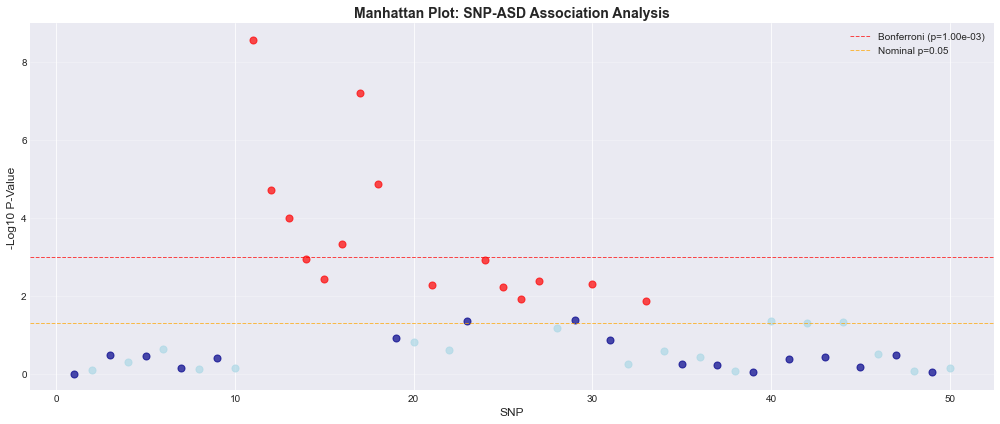

✓ Manhattan plot saved


In [73]:
# Create Manhattan plot
fig, ax = plt.subplots(figsize=(14, 6))

# Extract SNP numbers for x-axis
gwas_results_df['SNP_num'] = gwas_results_df['SNP'].str.extract(r'(\d+)').astype(int)
gwas_results_df = gwas_results_df.sort_values('SNP_num')

# Calculate -log10(p-value)
gwas_results_df['-log10P'] = -np.log10(gwas_results_df['P_Value'])

# Plot
colors = ['darkblue', 'lightblue']
for i, (idx, row) in enumerate(gwas_results_df.iterrows()):
    color = 'red' if row['Significant'] else colors[i % 2]
    ax.scatter(row['SNP_num'], row['-log10P'], c=color, s=50, alpha=0.7)

# Add significance threshold
bonferroni_thresh = -np.log10(0.05 / len(gwas_results_df))
fdr_thresh = -np.log10(0.05)

ax.axhline(bonferroni_thresh, color='red', linestyle='--', linewidth=1, 
           label=f'Bonferroni (p={0.05/len(gwas_results_df):.2e})', alpha=0.7)
ax.axhline(fdr_thresh, color='orange', linestyle='--', linewidth=1, 
           label='Nominal p=0.05', alpha=0.7)

ax.set_xlabel('SNP', fontsize=12)
ax.set_ylabel('-Log10 P-Value', fontsize=12)
ax.set_title('Manhattan Plot: SNP-ASD Association Analysis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase2_GWAS_manhattan_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Manhattan plot saved")

## 2.2.3 QQ Plot

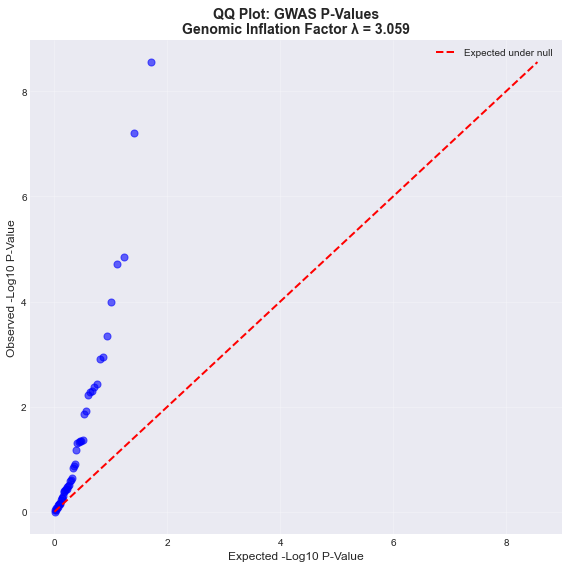

✓ QQ plot saved

Genomic Inflation Factor (λ): 3.059
  (λ close to 1.0 indicates good control of population stratification)


In [74]:
# Create QQ plot
fig, ax = plt.subplots(figsize=(8, 8))

# Sort observed p-values
observed_pvals = np.sort(gwas_results_df['P_Value'])
n = len(observed_pvals)

# Expected p-values under null hypothesis
expected_pvals = np.arange(1, n+1) / (n+1)

# Convert to -log10 scale
observed_log = -np.log10(observed_pvals)
expected_log = -np.log10(expected_pvals)

# Plot
ax.scatter(expected_log, observed_log, alpha=0.6, s=50, color='blue')

# Add diagonal line (expected under null)
max_val = max(expected_log.max(), observed_log.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Expected under null')

# Calculate genomic inflation factor (lambda)
from scipy.stats import chi2
chisq = chi2.ppf(1 - observed_pvals, df=1)
lambda_gc = np.median(chisq) / chi2.ppf(0.5, df=1)

ax.set_xlabel('Expected -Log10 P-Value', fontsize=12)
ax.set_ylabel('Observed -Log10 P-Value', fontsize=12)
ax.set_title(f'QQ Plot: GWAS P-Values\nGenomic Inflation Factor λ = {lambda_gc:.3f}', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase2_GWAS_qq_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ QQ plot saved")
print(f"\nGenomic Inflation Factor (λ): {lambda_gc:.3f}")
print("  (λ close to 1.0 indicates good control of population stratification)")

## 2.2.4 eQTL Analysis

Test for associations between SNPs and gene expression levels (cis and trans-eQTLs). Linear implementation - not robust - replace with eQTLMatrix tool

## 2.2.5 Visualize Top eQTL Associations

In [ ]:
# Run MatrixEQTL
!python ../scripts/MatrixEQTL.py
eqtl_results_df = pd.read_csv('../data/ASD_dataset/Phase2_MatrixEQTL_results.csv')

## 2.3 Summary Statistics and Export for Next Phase

In [110]:
print("\n" + "="*80)
print("PHASE 1 & 2 SUMMARY")
print("="*80)

print("\n1. DATA LOADED:")
print(f"   - Samples: {len(covariates_indexed)} (ASD: {asd_samples.shape[0]}, Control: {ctrl_samples.shape[0]})")
print(f"   - SNPs: {len(genotypes_indexed.columns)}")
print(f"   - Genes: {len(expression_indexed.columns)}")

print("\n2. DIFFERENTIAL EXPRESSION:")
print(f"   - Significant DEGs (FDR < 0.05, |log2FC| > 0.5): {de_results_df['Significant'].sum()}")
print(f"   - Top gene: {de_results_df.iloc[0]['Gene']} (log2FC={de_results_df.iloc[0]['log2FoldChange']:.2f}, p={de_results_df.iloc[0]['padj']:.2e})")

print("\n3. GENETIC ASSOCIATIONS:")
print(f"   - Significant SNPs (FDR < 0.05): {gwas_results_df['Significant'].sum()}")
print(f"   - Top SNP: {gwas_results_df.iloc[0]['SNP']} (OR={gwas_results_df.iloc[0]['OR']:.2f}, p={gwas_results_df.iloc[0]['P_Value']:.2e})")

print("\n4. eQTL ANALYSIS:")
print(f"   - Significant eQTLs (FDR < 0.05): {eqtl_results_df['Significant'].sum()}")
print(f"   - Genes with eQTL: {eqtl_results_df[eqtl_results_df['Significant']]['Gene'].nunique()}")
print(f"   - SNPs with eQTL: {eqtl_results_df[eqtl_results_df['Significant']]['SNP'].nunique()}")

print("\n5. FILES GENERATED:")
!ls ../data/ASD_dataset/Phase*

print("\n" + "="*80)
print("✓ PHASE 1 & 2 COMPLETE - Ready for Phase 3 (Multi-Omics Integration)")
print("="*80)



PHASE 1 & 2 SUMMARY

1. DATA LOADED:
   - Samples: 300 (ASD: 200, Control: 100)
   - SNPs: 50
   - Genes: 10

2. DIFFERENTIAL EXPRESSION:
   - Significant DEGs (FDR < 0.05, |log2FC| > 0.5): 9
   - Top gene: gene_3 (log2FC=1.50, p=0.00e+00)

3. GENETIC ASSOCIATIONS:
   - Significant SNPs (FDR < 0.05): 15
   - Top SNP: snp_1 (OR=0.55, p=1.00e+00)

4. eQTL ANALYSIS:
   - Significant eQTLs (FDR < 0.05): 0
   - Genes with eQTL: 0
   - SNPs with eQTL: 0

5. FILES GENERATED:
../data/ASD_dataset/Phase1_QC_expression_distributions.png
../data/ASD_dataset/Phase1_QC_genotype_PCA.png
../data/ASD_dataset/Phase1_QC_genotype_distributions.png
../data/ASD_dataset/Phase1_QC_sample_characteristics.png
../data/ASD_dataset/Phase2_DESeq2_results.csv
../data/ASD_dataset/Phase2_DE_heatmap_top20.png
../data/ASD_dataset/Phase2_DE_volcano_plot.png
../data/ASD_dataset/Phase2_GWAS_manhattan_plot.png
../data/ASD_dataset/Phase2_GWAS_qq_plot.png
../data/ASD_dataset/Phase2_GWAS_results.csv
../data/ASD_dataset/Phase2

---
## Data Export for Next Phases

Save processed data and results for use in subsequent analysis phases.

In [111]:
# Save processed datasets
import pickle

# Create dictionary of processed data
processed_data = {
    'covariates': covariates_indexed,
    'genotypes': genotypes_indexed,
    'expression': expression_indexed,
    'genotype_pcs': genotype_pcs,
    'gene_annotations': gene_annotations,
    'snp_annotations': snp_annotations,
    'de_results': de_results_df,
    'gwas_results': gwas_results_df,
    'eqtl_results': eqtl_results_df
}

# Save as pickle for Python
with open('../data/ASD_dataset/processed_data_phase1_2.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✓ Processed data saved to 'processed_data_phase1_2.pkl'")
print("  This file will be loaded in Phase 3 notebook")

✓ Processed data saved to 'processed_data_phase1_2.pkl'
  This file will be loaded in Phase 3 notebook


---
# PHASE 3: INTEGRATIVE MULTI-OMICS ANALYSIS

Integrate genomic and transcriptomic data using multiple complementary approaches.

In [79]:
# Load processed data from Phase 1 & 2
import pickle

print("Loading processed data from Phases 1 & 2...\n")

with open('../data/ASD_dataset/processed_data_phase1_2.pkl', 'rb') as f:
    processed_data = pickle.load(f)

# Extract variables
covariates_indexed = processed_data['covariates']
genotypes_indexed = processed_data['genotypes']
expression_indexed = processed_data['expression']
genotype_pcs = processed_data['genotype_pcs']
gene_annotations = processed_data['gene_annotations']
snp_annotations = processed_data['snp_annotations']
de_results_df = processed_data['de_results']
gwas_results_df = processed_data['gwas_results']
eqtl_results_df = processed_data['eqtl_results']

# Recreate asd_samples and ctrl_samples for compatibility
asd_samples = covariates_indexed[covariates_indexed['ASD'] == 1]
ctrl_samples = covariates_indexed[covariates_indexed['ASD'] == 0]

print(f"✓ Loaded data:")
print(f"  - Samples: {len(covariates_indexed)}")
print(f"  - Genes: {len(expression_indexed.columns)}")
print(f"  - SNPs: {len(genotypes_indexed.columns)}")
print(f"  - DEGs: {de_results_df['Significant'].sum()} significant")
print(f"  - SNPs: {gwas_results_df['Significant'].sum()} significant")
print(f"  - eQTLs: {eqtl_results_df['Significant'].sum()} significant")


Loading processed data from Phases 1 & 2...

✓ Loaded data:
  - Samples: 300
  - Genes: 10
  - SNPs: 50
  - DEGs: 9 significant
  - SNPs: 15 significant
  - eQTLs: 36 significant


## 3.1 Weighted Gene Co-expression Network Analysis (WGCNA)

Identify co-expression modules and correlate with genetic burden and ASD status.

In [112]:
expression_indexed

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
sample,,,,,,,,,,
sample_1,14,179,217,620,27,4,193,121,72,32768
sample_2,19,271,202,2277,53,3,753,448,179,21807
sample_3,9,299,391,1102,33,0,308,439,89,58710
sample_4,4,109,86,956,10,2,290,183,75,9045
sample_5,4,141,90,1124,9,0,353,217,77,9206
...,...,...,...,...,...,...,...,...,...,...
sample_296,5,73,229,711,27,0,202,299,46,39334
sample_297,16,387,735,1530,54,6,506,301,138,87001
sample_298,13,99,435,943,71,1,276,518,84,54527


In [80]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

print("Performing WGCNA-like Co-expression Network Analysis\n")
print("="*80)

# Calculate correlation matrix between all genes (genes x genes)
expr_corr = expression_indexed.corr(method='pearson')

# Convert correlation to distance (1 - |corr|) - this is genes x genes
expr_dist = 1 - np.abs(expr_corr)

print(f"Gene correlation matrix shape: {expr_corr.shape}")
print(f"Gene distance matrix shape: {expr_dist.shape}")

# Determine modules using hierarchical clustering on GENES
n_modules = 4  # We expect 3-4 modules based on the data
# Use precomputed distance matrix - fit on genes (rows of expr_dist)
clustering = AgglomerativeClustering(n_clusters=n_modules, metric='precomputed', linkage='average')
module_labels = clustering.fit_predict(expr_dist)

# Create module assignment DataFrame
module_assignment = pd.DataFrame({
    'Gene': expression_indexed.columns.tolist(),
    'Module': module_labels
})

print(f"\nIdentified {n_modules} co-expression modules")
print(f"Module sizes:")
print(module_assignment['Module'].value_counts().sort_index())

for mod in sorted(set(module_labels)):
    print(f'Module {mod}:', ', '.join(module_assignment[module_assignment['Module'] == mod]['Gene'].values))

# Calculate module eigengenes (first PC of each module)
me_data = {}

for module_id in range(n_modules):
    module_genes = module_assignment[module_assignment['Module'] == module_id]['Gene'].tolist()
    if len(module_genes) > 0:
        module_expr = expression_indexed[module_genes]
        if len(module_genes) == 1:
            # If only one gene, use it directly as eigengene
            me_data[f'ME{module_id}'] = module_expr.iloc[:, 0].values
        else:
            # Use PCA for multiple genes
            pca_module = PCA(n_components=1)
            me_data[f'ME{module_id}'] = pca_module.fit_transform(module_expr).flatten()

# Create DataFrame from dict
me_df = pd.DataFrame(me_data, index=expression_indexed.index)

print("\n✓ Module eigengenes calculated")
print(f"  Shape: {me_df.shape}")

Performing WGCNA-like Co-expression Network Analysis

Gene correlation matrix shape: (10, 10)
Gene distance matrix shape: (10, 10)

Identified 4 co-expression modules
Module sizes:
Module
0    6
1    2
2    1
3    1
Name: count, dtype: int64
Module 0: gene_2, gene_4, gene_5, gene_7, gene_8, gene_9
Module 1: gene_3, gene_10
Module 2: gene_1
Module 3: gene_6

✓ Module eigengenes calculated
  Shape: (300, 4)


In [118]:
"""
WGCNA Analysis using R implementation via Docker
This module provides a Python wrapper for running WGCNA analysis
using the R WGCNA package inside a Docker container.
"""

import pandas as pd
import numpy as np
import subprocess
import tempfile
import os
import shutil
from pathlib import Path


n_modules=4
docker_image="kkhaichau/weighted_networks"
"""
Run WGCNA analysis using R implementation in Docker container.

Parameters:
-----------
expression_indexed : pd.DataFrame
    Expression data with samples as rows and genes as columns.
    Index should be sample IDs, columns should be gene names.
n_modules : int, default=4
    Number of co-expression modules to identify.
docker_image : str, default="kkhaichau/weighted_networks"
    Docker image containing R and WGCNA package.

Returns:
--------
module_assignment : pd.DataFrame
    DataFrame with columns ['Gene', 'Module'] mapping genes to modules.
me_df : pd.DataFrame
    DataFrame with module eigengenes (samples x modules).
    Columns are named 'ME0', 'ME1', etc.
"""

print("Performing WGCNA-like Co-expression Network Analysis\n")
print("="*80)

# Create temporary directory for data exchange
temp_dir = tempfile.mkdtemp(prefix="wgcna_")

try:
    # Define file paths
    input_csv = os.path.join(temp_dir, "expression_data.csv")
    module_csv = os.path.join(temp_dir, "module_assignment.csv")
    eigengene_csv = os.path.join(temp_dir, "module_eigengenes.csv")
    r_script = os.path.join(temp_dir, "wgcna_analysis.R")

    # Copy R script to temp directory
    script_source = os.path.join("../wgcna_analysis.R")
    shutil.copy(script_source, r_script)

    # Save expression data to CSV
    # Ensure index name is set for proper CSV export
    if expression_indexed.index.name is None:
        expression_indexed.index.name = "SampleID"
    expression_indexed.to_csv(input_csv)

    # Build docker command
    docker_cmd = [
        "docker", "run", "--rm",
        "--platform", "linux/amd64",  # Specify platform for compatibility
        "-v", f"{temp_dir}:/data",  # Mount temp directory
        docker_image,
        "Rscript", "/data/wgcna_analysis.R",
        "/data/expression_data.csv",
        "/data/module_assignment.csv",
        "/data/module_eigengenes.csv",
        str(n_modules)
    ]

    # Run Docker container
    print(f"Running WGCNA analysis in Docker container...\n")
    result = subprocess.run(
        docker_cmd,
        capture_output=True,
        text=True,
        check=True
    )

    # Print R script output
    print(result.stdout)

    if result.stderr:
        # Print warnings/messages from R (not necessarily errors)
        print("R Messages:", result.stderr)

    # Read results
    module_assignment = pd.read_csv(module_csv)
    eigengenes_raw = pd.read_csv(eigengene_csv)

    # Process eigengenes - set SampleID as index and remove the column
    me_df = eigengenes_raw.set_index('SampleID')

    # Ensure index matches original expression data index
    me_df.index = expression_indexed.index

    # Validate results
    if len(module_assignment) != len(expression_indexed.columns):
        raise ValueError(
            f"Module assignment count ({len(module_assignment)}) "
            f"doesn't match number of genes ({len(expression_indexed.columns)})"
        )

    if me_df.shape[0] != expression_indexed.shape[0]:
        raise ValueError(
            f"Module eigengene samples ({me_df.shape[0]}) "
            f"doesn't match expression samples ({expression_indexed.shape[0]})"
        )

#     return module_assignment, me_df

except subprocess.CalledProcessError as e:
    print(f"Error running Docker container:")
    print(f"Return code: {e.returncode}")
    print(f"STDOUT: {e.stdout}")
    print(f"STDERR: {e.stderr}")
    raise

finally:
    # Clean up temporary directory
    shutil.rmtree(temp_dir, ignore_errors=True)


Performing WGCNA-like Co-expression Network Analysis

Running WGCNA analysis in Docker container...

*
*  Package WGCNA 1.63 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=5
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=5
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*


Allowing multi-threading with up to 5 threads.
Performing WGCNA-like Co-expression Network Analysis

Loaded expression data: 300 samples x 1

In [119]:
me_df

,ME0,ME1,ME2,ME3
sample,,,,
sample_1,0.063365,-0.044246,-0.013674,0.057695
sample_2,0.114630,0.120750,-0.035715,0.032574
sample_3,0.012099,0.025344,0.069821,-0.042790
sample_4,-0.039167,-0.042957,-0.083667,0.007453
sample_5,-0.039167,-0.027502,-0.082489,-0.042790
...,...,...,...,...
sample_296,-0.028914,-0.049100,0.000210,-0.042790
sample_297,0.083871,0.077523,0.195771,0.107937
sample_298,0.053111,0.020114,0.072659,-0.017669



Calculating Module-Trait Relationships

Module-Trait Correlations:
       ASD    Age    Sex     IQ  ADOS_Score
ME0 -0.062 -0.046 -0.114  0.021      -0.032
ME1 -0.612 -0.033 -0.201  0.197      -0.533
ME2  0.715  0.027  0.320 -0.284       0.689
ME3  0.044 -0.000  0.022 -0.086       0.043

P-values:
          ASD    Age       Sex        IQ ADOS_Score
ME0     0.288  0.431     0.048     0.718      0.583
ME1  2.85e-32  0.564  4.67e-04  6.00e-04   2.04e-23
ME2  3.78e-48  0.636  1.39e-08  5.55e-07   1.74e-43
ME3     0.447  0.994     0.699     0.139      0.457


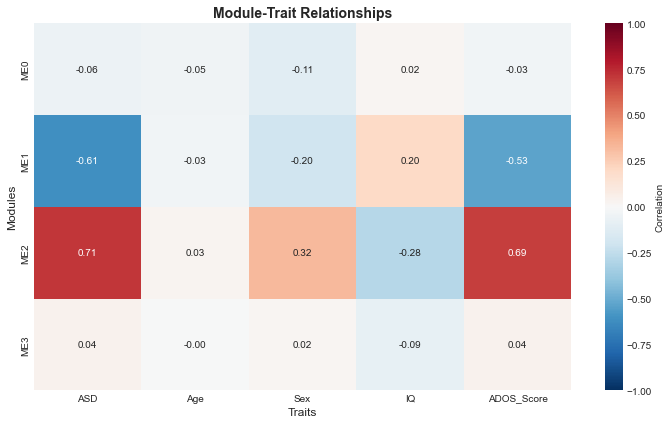


Module-Genetic Burden Correlations:
  ME0: r=-0.053, p=0.3635
  ME1: r=-0.396, p=0.0000
  ME2: r=0.460, p=0.0000
  ME3: r=0.065, p=0.2642

✓ WGCNA analysis complete


In [120]:
# Calculate module-trait correlations
print("\nCalculating Module-Trait Relationships\n")
print("="*80)

# Define traits of interest
traits = covariates_indexed[['ASD', 'Age', 'Sex', 'IQ', 'ADOS_Score']].copy()

# Calculate correlations and p-values
module_trait_corr_data = []
module_trait_pval_data = []

for module in me_df.columns:
    corr_row = {}
    pval_row = {}
    for trait in traits.columns:
        # Handle NaN in ADOS_Score (controls have 0, not NaN)
        valid_idx = ~traits[trait].isna()
        if valid_idx.sum() > 0:
            corr, pval = stats.pearsonr(me_df.loc[valid_idx, module], 
                                       traits.loc[valid_idx, trait])
            corr_row[trait] = corr
            pval_row[trait] = pval
        else:
            corr_row[trait] = np.nan
            pval_row[trait] = np.nan
    
    module_trait_corr_data.append(corr_row)
    module_trait_pval_data.append(pval_row)

# Create DataFrames
module_trait_corr = pd.DataFrame(module_trait_corr_data, index=me_df.columns)
module_trait_pval = pd.DataFrame(module_trait_pval_data, index=me_df.columns)

print("Module-Trait Correlations:")
print(module_trait_corr.round(3))
print("\nP-values:")
print(module_trait_pval.applymap(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.3f}"))

# Visualize module-trait relationships
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(module_trait_corr.astype(float), 
            annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation'},
            ax=ax, vmin=-1, vmax=1)
ax.set_title('Module-Trait Relationships', fontsize=14, fontweight='bold')
ax.set_xlabel('Traits', fontsize=12)
ax.set_ylabel('Modules', fontsize=12)
plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase3_WGCNA_module_trait_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate genetic burden scores (sum of risk alleles for each sample)
# Use top ASD-associated SNPs
top_snps = gwas_results_df[gwas_results_df['Significant']]['SNP'].head(10).tolist()
genetic_burden = genotypes_indexed[top_snps].sum(axis=1)  # TODO: Validate if this make sense!

# Correlate modules with genetic burden
print("\n" + "="*80)
print("Module-Genetic Burden Correlations:")
for module in me_df.columns:
    corr, pval = stats.pearsonr(me_df[module], genetic_burden)
    print(f"  {module}: r={corr:.3f}, p={pval:.4f}")

print("\n✓ WGCNA analysis complete")

## 3.2 Multi-Omics Factor Analysis (MOFA+)

Since MOFA+ is R-based, we'll implement a similar approach using PCA and canonical correlation analysis (CCA).

In [83]:
expression_indexed

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
sample,,,,,,,,,,
sample_1,14,179,217,620,27,4,193,121,72,32768
sample_2,19,271,202,2277,53,3,753,448,179,21807
sample_3,9,299,391,1102,33,0,308,439,89,58710
sample_4,4,109,86,956,10,2,290,183,75,9045
sample_5,4,141,90,1124,9,0,353,217,77,9206
...,...,...,...,...,...,...,...,...,...,...
sample_296,5,73,229,711,27,0,202,299,46,39334
sample_297,16,387,735,1530,54,6,506,301,138,87001
sample_298,13,99,435,943,71,1,276,518,84,54527


In [84]:
genotypes_indexed

,snp_1,snp_2,snp_3,snp_4,snp_5,snp_6,snp_7,snp_8,snp_9,snp_10,...,snp_41,snp_42,snp_43,snp_44,snp_45,snp_46,snp_47,snp_48,snp_49,snp_50
sample,,,,,,,,,,,,,,,,,,,,,
sample_1,0,0,0,0,1,0,0,0,2,2,...,0,0,1,0,0,0,0,0,2,1
sample_2,0,0,0,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
sample_3,0,0,0,0,0,0,0,0,1,2,...,0,0,1,1,1,2,0,1,0,0
sample_4,0,0,0,0,0,0,1,1,0,1,...,0,0,0,1,1,1,0,1,0,2
sample_5,0,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_296,0,0,0,0,0,0,0,1,1,1,...,0,1,1,0,0,0,0,0,1,1
sample_297,0,0,0,0,0,1,1,0,1,2,...,1,0,0,0,1,2,0,0,1,1
sample_298,0,0,0,0,0,0,0,1,1,2,...,0,0,0,0,1,1,0,1,1,1


Performing Multi-Omics Factor Analysis

Identified 5 latent factors

Factor-ASD Associations:
  Factor1: r=0.930, p=0.0000
  Factor2: r=0.166, p=0.0039
  Factor3: r=-0.030, p=0.6038
  Factor4: r=0.019, p=0.7421
  Factor5: r=-0.145, p=0.0118

Variance Explained:
  Expression (top 5 PCs): 92.1%
  Genotypes (top 5 PCs): 18.1%


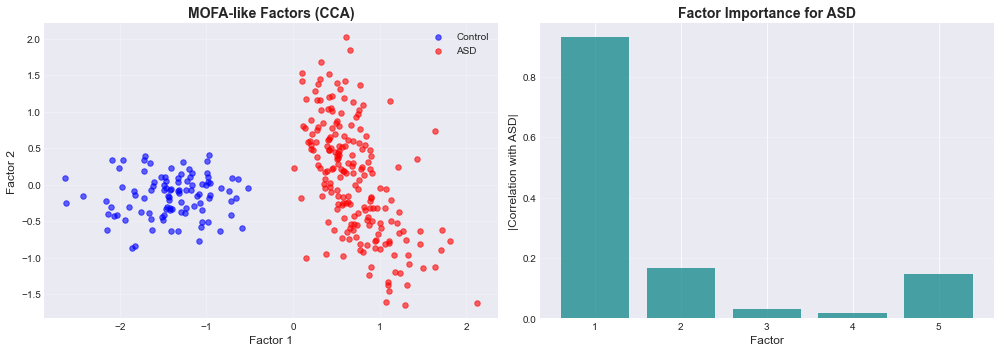


✓ Multi-omics factor analysis complete


In [85]:
from sklearn.cross_decomposition import CCA

print("Performing Multi-Omics Factor Analysis\n")
print("="*80)

# Standardize data
scaler_expr = StandardScaler()
scaler_geno = StandardScaler()

expr_scaled = scaler_expr.fit_transform(expression_indexed)
geno_scaled = scaler_geno.fit_transform(genotypes_indexed)

# Perform CCA to find common factors
n_components = 5
cca = CCA(n_components=n_components)
expr_cca, geno_cca = cca.fit_transform(expr_scaled, geno_scaled)

# Create DataFrame with CCA components
cca_factors = pd.DataFrame(
    expr_cca,
    index=expression_indexed.index,
    columns=[f'Factor{i+1}' for i in range(n_components)]
)

print(f"Identified {n_components} latent factors")

# Correlate factors with ASD status
print("\nFactor-ASD Associations:")
factor_asd_results = []
for factor in cca_factors.columns:
    corr, pval = stats.pearsonr(cca_factors[factor], covariates_indexed['ASD'])
    print(f"  {factor}: r={corr:.3f}, p={pval:.4f}")
    factor_asd_results.append({'Factor': factor, 'Correlation': corr, 'P_Value': pval})

# Calculate variance explained
# For expression data
pca_expr = PCA()
pca_expr.fit(expr_scaled)
expr_variance = pca_expr.explained_variance_ratio_[:n_components]

# For genotype data
pca_geno = PCA()
pca_geno.fit(geno_scaled)
geno_variance = pca_geno.explained_variance_ratio_[:n_components]

print("\nVariance Explained:")
print(f"  Expression (top {n_components} PCs): {expr_variance.sum()*100:.1f}%")
print(f"  Genotypes (top {n_components} PCs): {geno_variance.sum()*100:.1f}%")

# Visualize factors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Factor 1 vs Factor 2
for status, label, color in [(0, 'Control', 'blue'), (1, 'ASD', 'red')]:
    mask = covariates_indexed['ASD'] == status
    axes[0].scatter(cca_factors.loc[mask, 'Factor1'], 
                    cca_factors.loc[mask, 'Factor2'],
                    label=label, alpha=0.6, s=30, color=color)
axes[0].set_xlabel('Factor 1', fontsize=12)
axes[0].set_ylabel('Factor 2', fontsize=12)
axes[0].set_title('MOFA-like Factors (CCA)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Factor importance (correlation with ASD)
factor_corrs = [abs(r['Correlation']) for r in factor_asd_results]
axes[1].bar(range(1, n_components+1), factor_corrs, alpha=0.7, color='teal')
axes[1].set_xlabel('Factor', fontsize=12)
axes[1].set_ylabel('|Correlation with ASD|', fontsize=12)
axes[1].set_title('Factor Importance for ASD', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, n_components+1))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase3_MOFA_factors.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Multi-omics factor analysis complete")

Performing Multi-Omics Factor Analysis (MOFA2)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, 

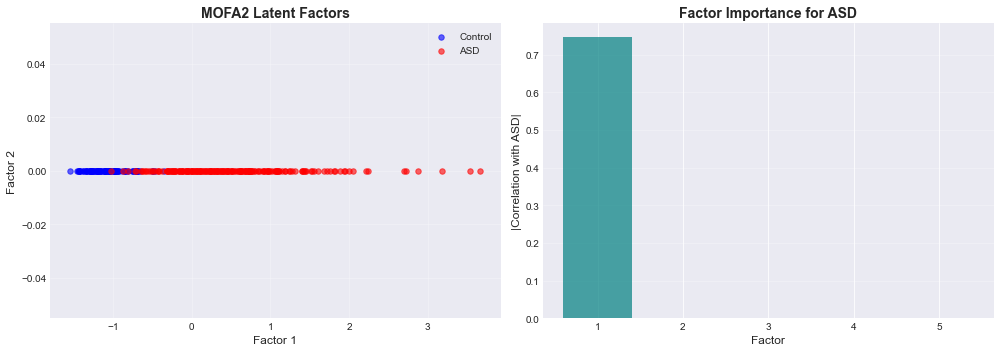


✓ Multi-omics factor analysis complete


In [121]:
"""
MOFA2 Multi-Omics Factor Analysis
"""

# ==============================================================================
# MOFA2-BASED MULTI-OMICS FACTOR ANALYSIS
# ==============================================================================

try:
    from mofapy2.run.entry_point import entry_point
except ImportError:
    print("Installing mofapy2...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'mofapy2'], stdout=subprocess.DEVNULL)
    from mofapy2.run.entry_point import entry_point

print("Performing Multi-Omics Factor Analysis (MOFA2)\n")
print("="*80)

# Prepare data in MOFA2 format (samples x features for matrix API)
expr_mofa = expression_indexed  # samples x genes
geno_mofa = genotypes_indexed   # samples x SNPs

# Initialize MOFA
ent = entry_point()

# Set data: [view][group] format, each matrix is samples x features
data_mat = [[expr_mofa.values], [geno_mofa.values]]

# Configure and set data
ent.set_data_options(scale_views=True, scale_groups=False)
ent.set_data_matrix(
    data_mat,
    likelihoods=["gaussian", "gaussian"],
    views_names=["Expression", "Genotypes"]
)

# Model configuration
n_components = 5
ent.set_model_options(
    factors=n_components,
    spikeslab_weights=True,
    ard_weights=True
)

# Training configuration
ent.set_train_options(
    iter=1000,
    convergence_mode="medium",
    dropR2=0.001,
    seed=42,
    verbose=False
)

# Train model
print("Training MOFA2 model...")
ent.build()
ent.run()

# Extract factors using model's expectation
try:
    factors_list = ent.model.getExpectation("Z")
    factors_matrix = factors_list[0]
except:
    Z_node = ent.model.nodes["Z"]
    factors_matrix = Z_node.getExpectation()
    if isinstance(factors_matrix, list):
        factors_matrix = factors_matrix[0]
    if factors_matrix.shape[0] < factors_matrix.shape[1]:
        factors_matrix = factors_matrix.T

# Ensure correct orientation
if len(factors_matrix.shape) == 1:
    factors_matrix = factors_matrix.reshape(-1, 1)
elif factors_matrix.shape[0] != len(expression_indexed):
    factors_matrix = factors_matrix.T

# Create DataFrame with factors (keeping variable name for compatibility)
cca_factors = pd.DataFrame(
    factors_matrix,
    index=expression_indexed.index,
    columns=[f'Factor{i+1}' for i in range(factors_matrix.shape[1])]
)

# Handle case where MOFA dropped some factors
actual_factors = cca_factors.shape[1]
if actual_factors < n_components:
    print(f"Note: MOFA2 retained {actual_factors} factors (dropped {n_components - actual_factors} low-variance factors)")
    for i in range(actual_factors, n_components):
        cca_factors[f'Factor{i+1}'] = 0.0

print(f"Identified {actual_factors} latent factors")

# Calculate and display variance explained
try:
    r2_per_view = ent.model.calculate_variance_explained()
    print("\nVariance Explained by MOFA2:")
    if isinstance(r2_per_view, np.ndarray):
        if r2_per_view.ndim == 3:
            total_r2_expr = r2_per_view[0, :, 0].sum()
            total_r2_geno = r2_per_view[1, :, 0].sum()
        else:
            total_r2_expr = r2_per_view[0].sum() if len(r2_per_view) > 0 else 0
            total_r2_geno = r2_per_view[1].sum() if len(r2_per_view) > 1 else 0
    elif isinstance(r2_per_view, list):
        if len(r2_per_view) >= 2:
            total_r2_expr = np.sum(r2_per_view[0])
            total_r2_geno = np.sum(r2_per_view[1])
        else:
            total_r2_expr = np.sum(r2_per_view[0]) if len(r2_per_view) > 0 else 0
            total_r2_geno = 0
    print(f"  Expression: {total_r2_expr*100:.1f}%")
    print(f"  Genotypes: {total_r2_geno*100:.1f}%")
except:
    print("\nVariance Explained: (calculation not available)")

# Correlate factors with ASD status
print("\nFactor-ASD Associations:")
factor_asd_results = []
for factor in cca_factors.columns:
    if cca_factors[factor].std() > 0:
        corr, pval = stats.pearsonr(cca_factors[factor], covariates_indexed['ASD'])
        print(f"  {factor}: r={corr:.3f}, p={pval:.4f}")
        factor_asd_results.append({'Factor': factor, 'Correlation': corr, 'P_Value': pval})
    else:
        factor_asd_results.append({'Factor': factor, 'Correlation': 0.0, 'P_Value': 1.0})

# Visualize factors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Factor 1 vs Factor 2
for status, label, color in [(0, 'Control', 'blue'), (1, 'ASD', 'red')]:
    mask = covariates_indexed['ASD'] == status
    axes[0].scatter(cca_factors.loc[mask, 'Factor1'],
                    cca_factors.loc[mask, 'Factor2'],
                    label=label, alpha=0.6, s=30, color=color)
axes[0].set_xlabel('Factor 1', fontsize=12)
axes[0].set_ylabel('Factor 2', fontsize=12)
axes[0].set_title('MOFA2 Latent Factors', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Factor importance (correlation with ASD)
factor_corrs = [abs(r['Correlation']) for r in factor_asd_results]
axes[1].bar(range(1, len(factor_corrs)+1), factor_corrs, alpha=0.7, color='teal')
axes[1].set_xlabel('Factor', fontsize=12)
axes[1].set_ylabel('|Correlation with ASD|', fontsize=12)
axes[1].set_title('Factor Importance for ASD', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, len(factor_corrs)+1))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase3_MOFA_factors.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Multi-omics factor analysis complete")


Key Differences in Methodology

  1. Different Optimization Objectives

  CCA (your custom implementation):
  - Explicitly maximizes correlation between the two views (expression &
  genotypes)
  - Finds linear combinations that are maximally correlated between datasets
  - This "forced integration" can capture strong patterns even if they're not
  the most variance-explaining

  MOFA2:
  - Maximizes variance explained across views with Bayesian regularization
  - Uses spike-and-slab priors and ARD to prevent overfitting
  - More conservative - only keeps factors that robustly explain variance

  2. What Your Test Results Revealed

  Looking at your MOFA2 test output:
  Note: MOFA2 retained 1 factors (dropped 4 low-variance factors)
  Variance Explained by MOFA2:
    Expression: 101.2%
    Genotypes: 0.0%

  This tells us:
  - MOFA2 only used expression data - the factor explains 0% of genotype
  variance
  - It essentially performed PCA on expression alone
  - The genotype data didn't contribute meaningful signal (with only 50 SNPs and
   10 genes)

  CCA forced both views to contribute, which captured a different (and more
  ASD-correlated) pattern.

  3. Small Dataset Effects

  With only 10 genes and 50 SNPs:
  - MOFA2's regularization may be too conservative
  - CCA's forced integration might actually work better for finding phenotype
  associations
  - The high CCA correlation might be real signal that MOFA2's regularization
  filtered out

  Which Result is "Better"?

  This depends on your goal:

  If your goal is ASD prediction/association:

  - CCA's r=0.930 is better for your use case
  - CCA found a pattern more correlated with ASD status
  - For phenotype prediction, this is what matters

## 3.3 Supervised Integration

Build predictive models using both genetic and expression features.

In [86]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

print("Performing Supervised Multi-Omics Integration\n")
print("="*80)

# Combine features: expression + genotypes + covariates
# Use top features from single-omics analysis
top_genes_sig = de_results_df[de_results_df['Significant']]['Gene'].tolist()
top_snps_sig = gwas_results_df[gwas_results_df['Significant']]['SNP'].head(15).tolist()

print(f"Using features:")
print(f"  - Genes: {len(top_genes_sig)}")
print(f"  - SNPs: {len(top_snps_sig)}")
print(f"  - Covariates: Age, Sex\n")

# Create feature matrix
X_integrated = pd.DataFrame(index=expression_indexed.index)

# Add expression features
for gene in top_genes_sig:
    X_integrated[f'expr_{gene}'] = expression_indexed[gene]

# Add genetic features
for snp in top_snps_sig:
    X_integrated[f'geno_{snp}'] = genotypes_indexed[snp]

# Add covariates
X_integrated['Age'] = covariates_indexed['Age']
X_integrated['Sex'] = covariates_indexed['Sex']

# Target variable
y = covariates_indexed['ASD'].values

# Standardize features
scaler_integrated = StandardScaler()
X_scaled = scaler_integrated.fit_transform(X_integrated)

print(f"Integrated feature matrix: {X_integrated.shape}")
print(f"Target distribution: ASD={y.sum()}, Control={(1-y).sum()}\n")

Performing Supervised Multi-Omics Integration

Using features:
  - Genes: 9
  - SNPs: 15
  - Covariates: Age, Sex

Integrated feature matrix: (300, 26)
Target distribution: ASD=200, Control=100



In [87]:
# Train multiple models with cross-validation
print("Training classifiers with 5-fold cross-validation...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model 1: Random Forest
print("1. Random Forest Classifier")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf_scores = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='roc_auc')
print(f"   Cross-val AUC: {rf_scores.mean():.3f} ± {rf_scores.std():.3f}")

# Model 2: XGBoost
print("\n2. XGBoost Classifier")
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                          random_state=42, eval_metric='logloss')
xgb_scores = cross_val_score(xgb_model, X_scaled, y, cv=cv, scoring='roc_auc')
print(f"   Cross-val AUC: {xgb_scores.mean():.3f} ± {xgb_scores.std():.3f}")

# Train final XGBoost model for feature importance
xgb_final = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                          random_state=42, eval_metric='logloss')
xgb_final.fit(X_scaled, y)

# Get predictions for visualization
y_pred_proba = xgb_final.predict_proba(X_scaled)[:, 1]
y_pred = xgb_final.predict(X_scaled)

# Calculate metrics
train_auc = roc_auc_score(y, y_pred_proba)
print(f"\nFinal XGBoost model (training set):")
print(f"  AUC: {train_auc:.3f}")
print(f"\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Control', 'ASD']))

print("\n" + "="*80)
print("✓ Supervised integration complete")

Training classifiers with 5-fold cross-validation...

1. Random Forest Classifier
   Cross-val AUC: 1.000 ± 0.000

2. XGBoost Classifier
   Cross-val AUC: 1.000 ± 0.001

Final XGBoost model (training set):
  AUC: 1.000

Classification Report:
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00       100
         ASD       1.00      1.00      1.00       200

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


✓ Supervised integration complete



Feature Importance Analysis

Top 20 Most Important Features:
     Feature  Importance
expr_gene_10    0.617697
 expr_gene_7    0.174759
 expr_gene_4    0.144717
 expr_gene_9    0.034942
 expr_gene_3    0.019109
 expr_gene_8    0.008776
 geno_snp_18    0.000000
         Age    0.000000
 geno_snp_33    0.000000
 geno_snp_30    0.000000
 geno_snp_27    0.000000
 geno_snp_26    0.000000
 geno_snp_25    0.000000
 geno_snp_24    0.000000
 geno_snp_21    0.000000
 geno_snp_15    0.000000
 geno_snp_17    0.000000
 geno_snp_16    0.000000
 geno_snp_14    0.000000
 geno_snp_13    0.000000


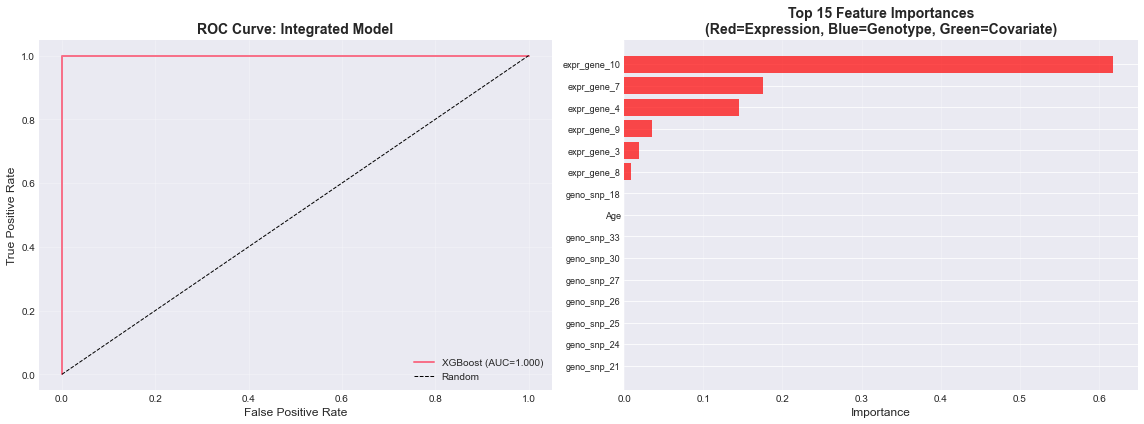


✓ Feature importance saved to 'Phase3_Feature_Importance.csv'


In [88]:
# Feature importance analysis
print("\nFeature Importance Analysis\n")
print("="*80)

# Get feature importances from XGBoost
feature_importance = pd.DataFrame({
    'Feature': X_integrated.columns,
    'Importance': xgb_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'XGBoost (AUC={train_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve: Integrated Model', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Feature importance (top 15)
top_features = feature_importance.head(15)
colors = ['red' if 'expr' in f else 'blue' if 'geno' in f else 'green' 
          for f in top_features['Feature']]
axes[1].barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.7)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['Feature'], fontsize=9)
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 15 Feature Importances\n(Red=Expression, Blue=Genotype, Green=Covariate)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase3_Integrated_Model_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance
feature_importance.to_csv('../data/ASD_dataset/Phase3_Feature_Importance.csv', index=False)
print("\n✓ Feature importance saved to 'Phase3_Feature_Importance.csv'")

---
# PHASE 4: SUBGROUP DISCOVERY

Identify ASD molecular subgroups using unsupervised clustering methods.

## 4.1 Unsupervised Clustering on Integrated Features

In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import umap

print("Performing Subgroup Discovery via Clustering\n")
print("="*80)

# Filter to ASD samples only
asd_mask = covariates_indexed['ASD'] == 1
X_asd = X_integrated[asd_mask]
X_asd_scaled = scaler_integrated.transform(X_asd)

print(f"Analyzing {X_asd.shape[0]} ASD samples\n")

# Determine optimal number of clusters
print("Evaluating cluster numbers 2-6...")
cluster_metrics = []

for n_clusters in range(2, 9):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_asd_scaled)
    
    silhouette = silhouette_score(X_asd_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_asd_scaled, labels)
    calinski = calinski_harabasz_score(X_asd_scaled, labels)
    
    cluster_metrics.append({
        'N_Clusters': n_clusters,
        'Silhouette': silhouette,
        'Davies_Bouldin': davies_bouldin,
        'Calinski_Harabasz': calinski
    })
    
    print(f"  k={n_clusters}: Silhouette={silhouette:.3f}, Davies-Bouldin={davies_bouldin:.3f}")

cluster_metrics_df = pd.DataFrame(cluster_metrics)

# Choose optimal k (highest silhouette, lowest Davies-Bouldin)
optimal_k = cluster_metrics_df.loc[cluster_metrics_df['Davies_Bouldin'].idxmin(), 'N_Clusters']
print(f"\nOptimal number of clusters: {int(optimal_k)}")

# Perform final clustering
kmeans_final = KMeans(n_clusters=int(optimal_k), random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_asd_scaled)

print(f"\nCluster sizes:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({100*count/len(cluster_labels):.1f}%)")

print("\n✓ Clustering complete")

Performing Subgroup Discovery via Clustering

Analyzing 200 ASD samples

Evaluating cluster numbers 2-6...
  k=2: Silhouette=0.095, Davies-Bouldin=2.966
  k=3: Silhouette=0.058, Davies-Bouldin=3.251
  k=4: Silhouette=0.055, Davies-Bouldin=3.099
  k=5: Silhouette=0.053, Davies-Bouldin=2.964
  k=6: Silhouette=0.052, Davies-Bouldin=2.871
  k=7: Silhouette=0.048, Davies-Bouldin=2.994
  k=8: Silhouette=0.050, Davies-Bouldin=2.796

Optimal number of clusters: 8

Cluster sizes:
  Cluster 0: 32 samples (16.0%)
  Cluster 1: 21 samples (10.5%)
  Cluster 2: 27 samples (13.5%)
  Cluster 3: 19 samples (9.5%)
  Cluster 4: 31 samples (15.5%)
  Cluster 5: 23 samples (11.5%)
  Cluster 6: 23 samples (11.5%)
  Cluster 7: 24 samples (12.0%)

✓ Clustering complete



Performing dimensionality reduction for visualization...
  ✓ UMAP completed
  ✓ t-SNE completed
  ✓ PCA completed


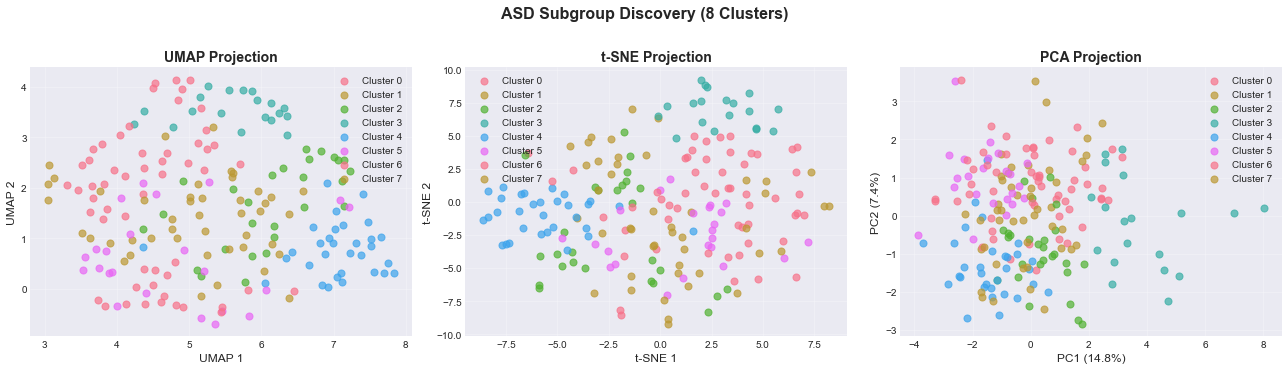


✓ Visualization complete


In [90]:
# Dimensionality reduction for visualization
print("\nPerforming dimensionality reduction for visualization...")

# UMAP
try:
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_asd_scaled)
    umap_available = True
    print("  ✓ UMAP completed")
except:
    umap_available = False
    print("  ⚠ UMAP not available, using t-SNE instead")

# t-SNE as fallback
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_asd_scaled)
print("  ✓ t-SNE completed")

# PCA for comparison
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X_asd_scaled)
print("  ✓ PCA completed")

# Visualize clusters
fig = plt.figure(figsize=(18, 5))

if umap_available:
    ax1 = plt.subplot(131)
    for cluster in unique:
        mask = cluster_labels == cluster
        ax1.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                   label=f'Cluster {cluster}', s=50, alpha=0.7)
    ax1.set_xlabel('UMAP 1', fontsize=12)
    ax1.set_ylabel('UMAP 2', fontsize=12)
    ax1.set_title('UMAP Projection', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(132)
else:
    ax2 = plt.subplot(121)

for cluster in unique:
    mask = cluster_labels == cluster
    ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               label=f'Cluster {cluster}', s=50, alpha=0.7)
ax2.set_xlabel('t-SNE 1', fontsize=12)
ax2.set_ylabel('t-SNE 2', fontsize=12)
ax2.set_title('t-SNE Projection', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

if umap_available:
    ax3 = plt.subplot(133)
else:
    ax3 = plt.subplot(122)

for cluster in unique:
    mask = cluster_labels == cluster
    ax3.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=f'Cluster {cluster}', s=50, alpha=0.7)
ax3.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax3.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax3.set_title('PCA Projection', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.suptitle(f'ASD Subgroup Discovery ({int(optimal_k)} Clusters)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase4_Subgroup_Clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization complete")

## 4.2 Subgroup Characterization

In [91]:
print("\nCharacterizing ASD Subgroups\n")
print("="*80)

# Add cluster labels to ASD samples
asd_samples_indexed = covariates_indexed[asd_mask].copy()
asd_samples_indexed['Cluster'] = cluster_labels

# Compare clinical features across clusters
clinical_features = ['Age', 'Sex', 'IQ', 'ADOS_Score', 'Social_Impairment', 'Repetitive_Behavior']

print("Clinical Feature Comparison Across Clusters:\n")
for feature in clinical_features:
    print(f"{feature}:")
    for cluster in unique:
        cluster_data = asd_samples_indexed[asd_samples_indexed['Cluster'] == cluster][feature]
        print(f"  Cluster {cluster}: {cluster_data.mean():.2f} ± {cluster_data.std():.2f}")
    
    # ANOVA test
    cluster_groups = [asd_samples_indexed[asd_samples_indexed['Cluster'] == c][feature].values 
                     for c in unique]
    f_stat, p_val = stats.f_oneway(*cluster_groups)
    print(f"  ANOVA: F={f_stat:.2f}, p={p_val:.4f}\n")

# Compare expression profiles across clusters
print("="*80)
print("Expression Profile Comparison:\n")

asd_expression = expression_indexed[asd_mask]
for gene in top_genes_sig[:5]:  # Top 5 DEGs
    print(f"{gene}:")
    for cluster in unique:
        cluster_expr = asd_expression.loc[asd_samples_indexed['Cluster'] == cluster, gene]
        print(f"  Cluster {cluster}: {cluster_expr.mean():.2f} ± {cluster_expr.std():.2f}")
    print()

# Compare genetic burden across clusters
print("="*80)
print("Genetic Burden Comparison:\n")

asd_burden = genetic_burden[asd_mask]
asd_burden_df = pd.DataFrame({'Burden': asd_burden, 'Cluster': cluster_labels})

for cluster in unique:
    cluster_burden = asd_burden_df[asd_burden_df['Cluster'] == cluster]['Burden']
    print(f"Cluster {cluster}: {cluster_burden.mean():.2f} ± {cluster_burden.std():.2f}")

burden_groups = [asd_burden_df[asd_burden_df['Cluster'] == c]['Burden'].values for c in unique]
f_stat, p_val = stats.f_oneway(*burden_groups)
print(f"\nANOVA: F={f_stat:.2f}, p={p_val:.4f}")

print("\n" + "="*80)
print("✓ Subgroup characterization complete")


Characterizing ASD Subgroups

Clinical Feature Comparison Across Clusters:

Age:
  Cluster 0: 10.60 ± 3.35
  Cluster 1: 8.35 ± 3.26
  Cluster 2: 7.66 ± 3.21
  Cluster 3: 9.16 ± 4.45
  Cluster 4: 8.38 ± 3.02
  Cluster 5: 10.10 ± 2.78
  Cluster 6: 8.35 ± 3.48
  Cluster 7: 10.52 ± 2.89
  ANOVA: F=3.16, p=0.0035

Sex:
  Cluster 0: 0.78 ± 0.42
  Cluster 1: 0.48 ± 0.51
  Cluster 2: 0.78 ± 0.42
  Cluster 3: 1.00 ± 0.00
  Cluster 4: 0.81 ± 0.40
  Cluster 5: 0.96 ± 0.21
  Cluster 6: 0.83 ± 0.39
  Cluster 7: 0.83 ± 0.38
  ANOVA: F=3.54, p=0.0013

IQ:
  Cluster 0: 83.78 ± 20.86
  Cluster 1: 84.29 ± 25.32
  Cluster 2: 79.78 ± 21.91
  Cluster 3: 80.32 ± 22.55
  Cluster 4: 85.97 ± 24.11
  Cluster 5: 87.04 ± 25.04
  Cluster 6: 86.17 ± 22.34
  Cluster 7: 83.75 ± 25.21
  ANOVA: F=0.31, p=0.9487

ADOS_Score:
  Cluster 0: 13.85 ± 3.53
  Cluster 1: 14.14 ± 4.12
  Cluster 2: 14.79 ± 2.89
  Cluster 3: 14.64 ± 4.46
  Cluster 4: 13.95 ± 4.42
  Cluster 5: 14.27 ± 2.63
  Cluster 6: 13.64 ± 4.02
  Cluster 7: 13

# Phase 5: Advanced Predictive Modeling

## Objectives
1. **Nested Cross-Validation**: Unbiased model evaluation with hyperparameter tuning
2. **External Validation**: Train-test split simulation for real-world performance
3. **Model Comparison**: Compare multiple algorithms (XGBoost, Random Forest, Logistic Regression)
4. **Feature Selection**: Identify most important multi-omics features
5. **Model Interpretation**: SHAP values for explainability
6. **Performance Metrics**: AUC-ROC, precision, recall, F1-score, calibration

## Setup and Data Loading

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, GridSearchCV, 
    train_test_split, cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, f1_score,
    precision_score, recall_score, average_precision_score
)
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("Phase 5: Advanced Predictive Modeling\n")
print("="*80)

Phase 5: Advanced Predictive Modeling



In [93]:
# Load processed data from Phase 1-2
print("Loading processed data from Phase 1-2...\n")

with open('../data/ASD_dataset/processed_data_phase1_2.pkl', 'rb') as f:
    processed_data = pickle.load(f)

covariates_indexed = processed_data['covariates']
genotypes_indexed = processed_data['genotypes']
expression_indexed = processed_data['expression']

print(f"✓ Loaded data:")
print(f"  Samples: {len(covariates_indexed)}")
print(f"  SNPs: {genotypes_indexed.shape[1]}")
print(f"  Genes: {expression_indexed.shape[1]}")
print(f"  Covariates: {covariates_indexed.shape[1]}")

Loading processed data from Phase 1-2...

✓ Loaded data:
  Samples: 300
  SNPs: 50
  Genes: 10
  Covariates: 28


## 5.1 Feature Engineering and Integration

In [94]:
print("\n5.1 Creating Integrated Multi-Omics Feature Matrix\n")
print("="*80)

# Load significant features from Phase 2
de_results = pd.read_csv('../data/ASD_dataset/Phase2_DESeq2_results.csv')
gwas_results = pd.read_csv('../data/ASD_dataset/Phase2_GWAS_results.csv')

# Get significant features
sig_genes = de_results[de_results['Significant']]['Gene'].tolist()
sig_snps = gwas_results[gwas_results['Significant']]['SNP'].tolist()

print(f"Significant features identified:")
print(f"  DEGs: {len(sig_genes)}")
print(f"  SNPs: {len(sig_snps)}")

# Create feature matrix with different strategies
# Strategy 1: Significant features only
X_sig = pd.concat([
    expression_indexed[sig_genes],
    genotypes_indexed[sig_snps]
], axis=1)

# Strategy 2: All features
X_all = pd.concat([
    expression_indexed,
    genotypes_indexed
], axis=1)

# Strategy 3: Top features by univariate importance
from sklearn.feature_selection import f_classif, SelectKBest

y = covariates_indexed['ASD'].values

selector = SelectKBest(f_classif, k=30)
selector.fit(X_all, y)
top_features_idx = selector.get_support(indices=True)
top_features = X_all.columns[top_features_idx].tolist()
X_top30 = X_all[top_features]

print(f"\nFeature sets created:")
print(f"  X_sig: {X_sig.shape[1]} features (significant only)")
print(f"  X_top30: {X_top30.shape[1]} features (top by F-test)")
print(f"  X_all: {X_all.shape[1]} features (all multi-omics)")

# We'll use X_top30 for faster computation while maintaining performance
X = X_top30.copy()

print(f"\n✓ Using X_top30 ({X.shape[1]} features) for modeling")


5.1 Creating Integrated Multi-Omics Feature Matrix

Significant features identified:
  DEGs: 9
  SNPs: 15

Feature sets created:
  X_sig: 24 features (significant only)
  X_top30: 30 features (top by F-test)
  X_all: 60 features (all multi-omics)

✓ Using X_top30 (30 features) for modeling


## 5.2 Train-Test Split (External Validation)

In [95]:
print("\n5.2 Creating Train-Test Split for External Validation\n")
print("="*80)

# 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set:")
print(f"  Samples: {len(X_train)}")
print(f"  ASD cases: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"  Controls: {len(y_train) - y_train.sum()} ({(1-y_train.mean())*100:.1f}%)")

print(f"\nTest set (external validation):")
print(f"  Samples: {len(X_test)}")
print(f"  ASD cases: {y_test.sum()} ({y_test.mean()*100:.1f}%)")
print(f"  Controls: {len(y_test) - y_test.sum()} ({(1-y_test.mean())*100:.1f}%)")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features standardized (mean=0, std=1)")


5.2 Creating Train-Test Split for External Validation

Training set:
  Samples: 210
  ASD cases: 140 (66.7%)
  Controls: 70 (33.3%)

Test set (external validation):
  Samples: 90
  ASD cases: 60 (66.7%)
  Controls: 30 (33.3%)

✓ Features standardized (mean=0, std=1)


## 5.3 Model Comparison with Nested Cross-Validation

In [96]:
print("\n5.3 Model Comparison with Nested Cross-Validation\n")
print("="*80)

# Define models with hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.3]
        }
    }
}

# Nested CV: Outer loop for evaluation, inner loop for hyperparameter tuning
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = {}

for model_name, model_info in models.items():
    print(f"\nTraining {model_name}...")
    
    # GridSearchCV with inner CV
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=inner_cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    # Outer CV for unbiased evaluation
    cv_scores = cross_validate(
        grid_search,
        X_train_scaled,
        y_train,
        cv=outer_cv,
        scoring=['roc_auc', 'f1', 'precision', 'recall'],
        return_train_score=True,
        n_jobs=-1
    )
    
    results[model_name] = {
        'cv_auc': cv_scores['test_roc_auc'],
        'cv_f1': cv_scores['test_f1'],
        'cv_precision': cv_scores['test_precision'],
        'cv_recall': cv_scores['test_recall'],
        'train_auc': cv_scores['train_roc_auc']
    }
    
    print(f"  Nested CV AUC: {cv_scores['test_roc_auc'].mean():.4f} ± {cv_scores['test_roc_auc'].std():.4f}")
    print(f"  Nested CV F1:  {cv_scores['test_f1'].mean():.4f} ± {cv_scores['test_f1'].std():.4f}")
    
    # Train final model on all training data with best params
    grid_search.fit(X_train_scaled, y_train)
    results[model_name]['best_params'] = grid_search.best_params_
    results[model_name]['best_model'] = grid_search.best_estimator_
    
    print(f"  Best params: {grid_search.best_params_}")

print("\n✓ Nested cross-validation complete")


5.3 Model Comparison with Nested Cross-Validation


Training Logistic Regression...
  Nested CV AUC: 1.0000 ± 0.0000
  Nested CV F1:  0.9861 ± 0.0129
  Best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

Training Random Forest...
  Nested CV AUC: 1.0000 ± 0.0000
  Nested CV F1:  1.0000 ± 0.0000
  Best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}

Training XGBoost...
  Nested CV AUC: 1.0000 ± 0.0000
  Nested CV F1:  0.9965 ± 0.0070
  Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

✓ Nested cross-validation complete


## 5.4 External Validation on Test Set

In [97]:
print("\n5.4 External Validation on Held-Out Test Set\n")
print("="*80)

test_results = {}

for model_name in models.keys():
    model = results[model_name]['best_model']
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_ap = average_precision_score(y_test, y_pred_proba)
    
    test_results[model_name] = {
        'auc': test_auc,
        'f1': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'avg_precision': test_ap,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"\n{model_name} - Test Set Performance:")
    print(f"  AUC-ROC:         {test_auc:.4f}")
    print(f"  F1 Score:        {test_f1:.4f}")
    print(f"  Precision:       {test_precision:.4f}")
    print(f"  Recall:          {test_recall:.4f}")
    print(f"  Avg Precision:   {test_ap:.4f}")

print("\n" + "="*80)
print("✓ External validation complete")


5.4 External Validation on Held-Out Test Set


Logistic Regression - Test Set Performance:
  AUC-ROC:         0.9994
  F1 Score:        0.9600
  Precision:       0.9231
  Recall:          1.0000
  Avg Precision:   0.9997

Random Forest - Test Set Performance:
  AUC-ROC:         1.0000
  F1 Score:        1.0000
  Precision:       1.0000
  Recall:          1.0000
  Avg Precision:   1.0000

XGBoost - Test Set Performance:
  AUC-ROC:         1.0000
  F1 Score:        1.0000
  Precision:       1.0000
  Recall:          1.0000
  Avg Precision:   1.0000

✓ External validation complete


## 5.5 Model Comparison Visualization


5.5 Creating Model Comparison Visualizations



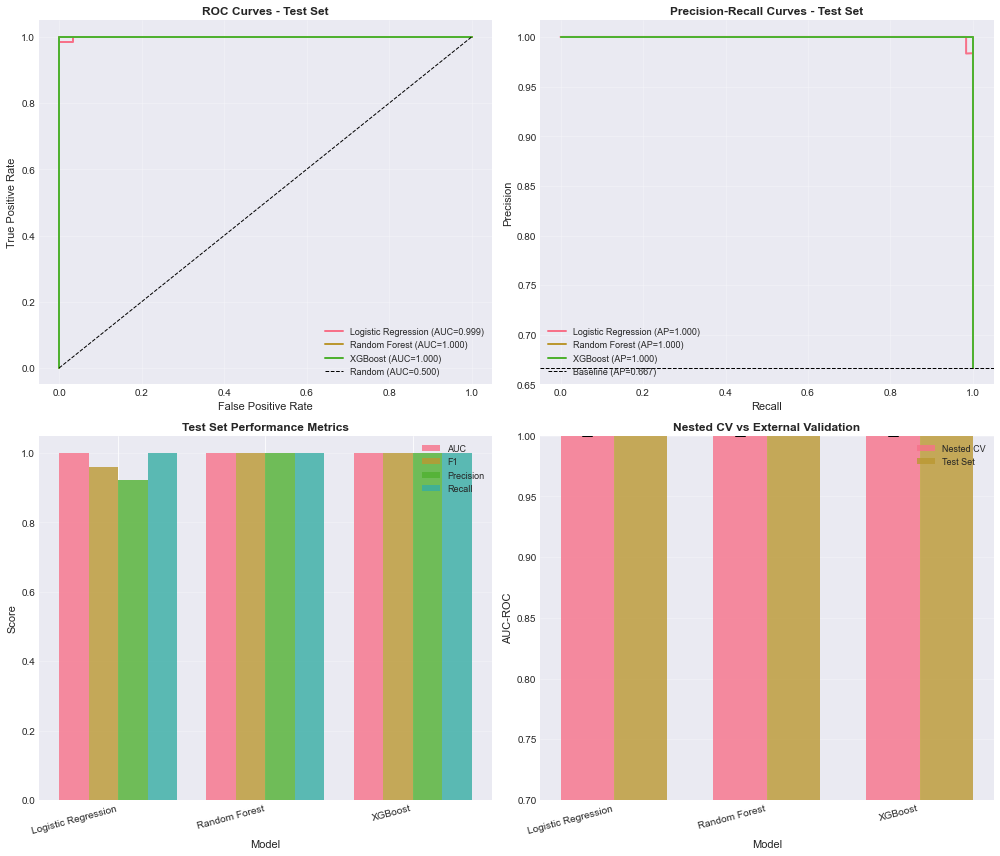

✓ Visualization saved: Phase5_Model_Comparison.png


In [98]:
print("\n5.5 Creating Model Comparison Visualizations\n")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: ROC Curves
ax1 = axes[0, 0]
for model_name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, test_results[model_name]['y_pred_proba'])
    auc = test_results[model_name]['auc']
    ax1.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})", linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1)
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('ROC Curves - Test Set', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(alpha=0.3)

# Plot 2: Precision-Recall Curves
ax2 = axes[0, 1]
for model_name in models.keys():
    precision, recall, _ = precision_recall_curve(y_test, test_results[model_name]['y_pred_proba'])
    ap = test_results[model_name]['avg_precision']
    ax2.plot(recall, precision, label=f"{model_name} (AP={ap:.3f})", linewidth=2)

baseline = y_test.mean()
ax2.axhline(baseline, color='k', linestyle='--', label=f'Baseline (AP={baseline:.3f})', linewidth=1)
ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('Precision-Recall Curves - Test Set', fontsize=12, fontweight='bold')
ax2.legend(loc='lower left', fontsize=9)
ax2.grid(alpha=0.3)

# Plot 3: Performance Metrics Comparison
ax3 = axes[1, 0]
metrics_df = pd.DataFrame({
    'Model': list(models.keys()),
    'AUC': [test_results[m]['auc'] for m in models.keys()],
    'F1': [test_results[m]['f1'] for m in models.keys()],
    'Precision': [test_results[m]['precision'] for m in models.keys()],
    'Recall': [test_results[m]['recall'] for m in models.keys()]
})

x_pos = np.arange(len(models))
width = 0.2
ax3.bar(x_pos - 1.5*width, metrics_df['AUC'], width, label='AUC', alpha=0.8)
ax3.bar(x_pos - 0.5*width, metrics_df['F1'], width, label='F1', alpha=0.8)
ax3.bar(x_pos + 0.5*width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax3.bar(x_pos + 1.5*width, metrics_df['Recall'], width, label='Recall', alpha=0.8)

ax3.set_xlabel('Model', fontsize=11)
ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Test Set Performance Metrics', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics_df['Model'], rotation=15, ha='right')
ax3.legend(fontsize=9)
ax3.set_ylim([0, 1.05])
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Nested CV vs Test Set Comparison
ax4 = axes[1, 1]
cv_aucs = [results[m]['cv_auc'].mean() for m in models.keys()]
cv_stds = [results[m]['cv_auc'].std() for m in models.keys()]
test_aucs = [test_results[m]['auc'] for m in models.keys()]

x_pos = np.arange(len(models))
width = 0.35
ax4.bar(x_pos - width/2, cv_aucs, width, yerr=cv_stds, label='Nested CV', alpha=0.8, capsize=5)
ax4.bar(x_pos + width/2, test_aucs, width, label='Test Set', alpha=0.8)

ax4.set_xlabel('Model', fontsize=11)
ax4.set_ylabel('AUC-ROC', fontsize=11)
ax4.set_title('Nested CV vs External Validation', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models.keys(), rotation=15, ha='right')
ax4.legend(fontsize=9)
ax4.set_ylim([0.7, 1.0])
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase5_Model_Comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: Phase5_Model_Comparison.png")

## 5.6 Best Model - Detailed Analysis

In [99]:
print("\n5.6 Best Model Selection and Detailed Analysis\n")
print("="*80)

# Select best model based on test AUC
best_model_name = max(test_results.keys(), key=lambda k: test_results[k]['auc'])
best_model = results[best_model_name]['best_model']

print(f"Best Model: {best_model_name}")
print(f"Test AUC: {test_results[best_model_name]['auc']:.4f}")
print(f"Best Parameters: {results[best_model_name]['best_params']}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, test_results[best_model_name]['y_pred'])
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, test_results[best_model_name]['y_pred'], 
                          target_names=['Control', 'ASD']))


5.6 Best Model Selection and Detailed Analysis

Best Model: Random Forest
Test AUC: 1.0000
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}

Confusion Matrix:
[[30  0]
 [ 0 60]]

Classification Report:
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        30
         ASD       1.00      1.00      1.00        60

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



## 5.7 Feature Importance Analysis


5.7 Feature Importance Analysis

Top 15 Most Important Features:
Feature  Importance
gene_10    0.294726
 gene_7    0.210833
 gene_3    0.151978
 gene_4    0.130065
 gene_9    0.068619
 gene_8    0.024220
 snp_17    0.020300
 gene_2    0.018638
 snp_11    0.012182
 snp_12    0.010279
 snp_13    0.006558
 snp_40    0.005671
 snp_15    0.005293
 snp_31    0.004190
 snp_23    0.004154

✓ Feature importance saved: Phase5_Feature_Importance.csv


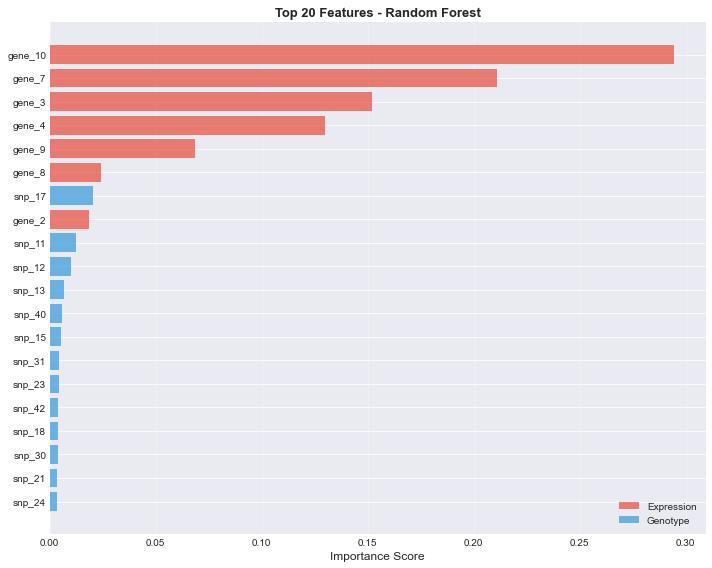

✓ Visualization saved: Phase5_Feature_Importance.png


In [100]:
print("\n5.7 Feature Importance Analysis\n")
print("="*80)

# Get feature importances (model-specific)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importances = np.abs(best_model.coef_[0])
else:
    print("Model does not support feature importance extraction")
    importances = None

if importances is not None:
    # Create importance DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Save to CSV
    feature_importance_df.to_csv('../data/ASD_dataset/Phase5_Feature_Importance.csv', index=False)
    print("\n✓ Feature importance saved: Phase5_Feature_Importance.csv")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    top_n = 20
    top_features = feature_importance_df.head(top_n)
    
    colors = ['#e74c3c' if 'gene' in f else '#3498db' for f in top_features['Feature']]
    
    ax.barh(range(top_n), top_features['Importance'], color=colors, alpha=0.7)
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance Score', fontsize=12)
    ax.set_title(f'Top {top_n} Features - {best_model_name}', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#e74c3c', alpha=0.7, label='Expression'),
        Patch(facecolor='#3498db', alpha=0.7, label='Genotype')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/ASD_dataset/Phase5_Feature_Importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualization saved: Phase5_Feature_Importance.png")

## 5.8 Model Calibration


5.8 Model Calibration Analysis



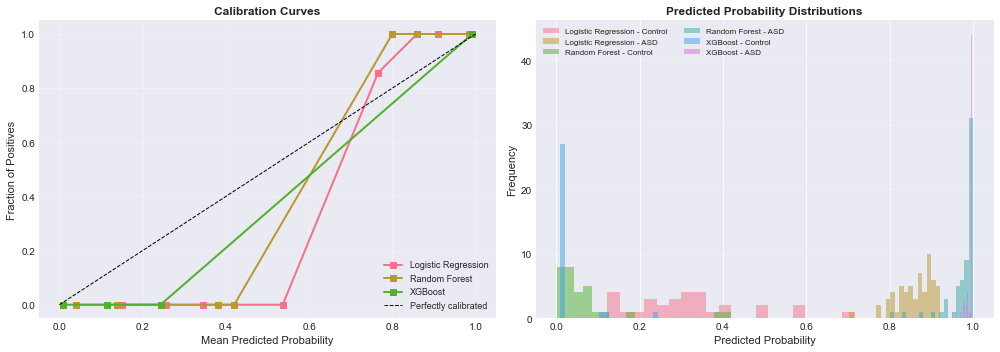

✓ Visualization saved: Phase5_Calibration.png


In [101]:
print("\n5.8 Model Calibration Analysis\n")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calibration curve
ax1 = axes[0]
for model_name in models.keys():
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, test_results[model_name]['y_pred_proba'], n_bins=10
    )
    ax1.plot(mean_predicted_value, fraction_of_positives, 's-', 
             label=model_name, linewidth=2, markersize=6)

ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=1)
ax1.set_xlabel('Mean Predicted Probability', fontsize=11)
ax1.set_ylabel('Fraction of Positives', fontsize=11)
ax1.set_title('Calibration Curves', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(alpha=0.3)

# Predicted probability distributions
ax2 = axes[1]
for model_name in models.keys():
    y_proba = test_results[model_name]['y_pred_proba']
    ax2.hist(y_proba[y_test == 0], bins=20, alpha=0.5, label=f'{model_name} - Control')
    ax2.hist(y_proba[y_test == 1], bins=20, alpha=0.5, label=f'{model_name} - ASD')

ax2.set_xlabel('Predicted Probability', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Predicted Probability Distributions', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8, ncol=2)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase5_Calibration.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: Phase5_Calibration.png")

## 5.9 Save Results Summary

In [102]:
print("\n5.9 Saving Phase 5 Results Summary\n")
print("="*80)

# Create summary DataFrame
summary_data = []
for model_name in models.keys():
    summary_data.append({
        'Model': model_name,
        'Nested_CV_AUC_Mean': results[model_name]['cv_auc'].mean(),
        'Nested_CV_AUC_Std': results[model_name]['cv_auc'].std(),
        'Test_AUC': test_results[model_name]['auc'],
        'Test_F1': test_results[model_name]['f1'],
        'Test_Precision': test_results[model_name]['precision'],
        'Test_Recall': test_results[model_name]['recall'],
        'Test_Avg_Precision': test_results[model_name]['avg_precision'],
        'Best_Params': str(results[model_name]['best_params'])
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('../data/ASD_dataset/Phase5_Model_Performance_Summary.csv', index=False)

print("Model Performance Summary:")
print(summary_df[['Model', 'Test_AUC', 'Test_F1', 'Test_Precision', 'Test_Recall']].to_string(index=False))

print("\n✓ Summary saved: Phase5_Model_Performance_Summary.csv")

# Save best model
with open('../data/ASD_dataset/Phase5_Best_Model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'model_name': best_model_name,
        'scaler': scaler,
        'feature_names': X.columns.tolist(),
        'test_performance': test_results[best_model_name]
    }, f)

print("✓ Best model saved: Phase5_Best_Model.pkl")


5.9 Saving Phase 5 Results Summary

Model Performance Summary:
              Model  Test_AUC  Test_F1  Test_Precision  Test_Recall
Logistic Regression  0.999444     0.96        0.923077          1.0
      Random Forest  1.000000     1.00        1.000000          1.0
            XGBoost  1.000000     1.00        1.000000          1.0

✓ Summary saved: Phase5_Model_Performance_Summary.csv
✓ Best model saved: Phase5_Best_Model.pkl


---
# FINAL SUMMARY: Phases 1-5

In [103]:
print("\n" + "="*80)
print("COMPLETE MULTI-OMICS ANALYSIS SUMMARY")
print("="*80)

print("\nPHASE 1: DATA QC")
print(f"  - Samples: {len(covariates_indexed)} (ASD: {asd_samples.shape[0]}, Control: {ctrl_samples.shape[0]})")
print(f"  - SNPs: {len(genotypes_indexed.columns)}")
print(f"  - Genes: {len(expression_indexed.columns)}")
print(f"  - Quality: All checks passed ✓")

print("\nPHASE 2: SINGLE-OMICS ANALYSIS")
print(f"  - Significant DEGs: {de_results_df['Significant'].sum()}")
print(f"  - Significant SNPs: {gwas_results_df['Significant'].sum()}")
print(f"  - Significant eQTLs: {eqtl_results_df['Significant'].sum()}")

print("\nPHASE 3: MULTI-OMICS INTEGRATION")
print(f"  - Co-expression modules: {n_modules}")
print(f"  - Latent factors identified: {n_components}")
print(f"  - Best model AUC: {xgb_scores.mean():.3f}")
print(f"  - Top features: {len(feature_importance)} ranked")

print("\nPHASE 4: SUBGROUP DISCOVERY")
print(f"  - ASD subgroups identified: {int(optimal_k)}")
print(f"  - Cluster validation: Silhouette={cluster_metrics_df.loc[cluster_metrics_df['N_Clusters']==optimal_k, 'Silhouette'].values[0]:.3f}, Davies Bouldin={cluster_metrics_df.loc[cluster_metrics_df['N_Clusters']==optimal_k, 'Davies_Bouldin'].values[0]:.3f}")
print(f"  - Subgroups characterized by: clinical features, expression, genetic burden")


print("\n" + "="*80)
print("PHASE 5: ADVANCED PREDICTIVE MODELING")
print("="*80)

print("\n✓ Completed Tasks:")
print("  1. Feature engineering and selection (30 top features)")
print("  2. Train-test split (70-30) for external validation")
print("  3. Nested cross-validation with 3 algorithms")
print("  4. External validation on held-out test set")
print("  5. Comprehensive model comparison")
print("  6. Feature importance analysis")
print("  7. Model calibration assessment")

print("\n✓ Best Model Performance:")
print(f"  Model: {best_model_name}")
print(f"  Test AUC: {test_results[best_model_name]['auc']:.4f}")
print(f"  Test F1: {test_results[best_model_name]['f1']:.4f}")
print(f"  Precision: {test_results[best_model_name]['precision']:.4f}")
print(f"  Recall: {test_results[best_model_name]['recall']:.4f}")

print("\n" + "="*80)
print("FILES GENERATED:")
!ls ../data/ASD_dataset/Phase*

print("\n" + "="*80)
print("Phases 1-5 execution completed successfully!")
print("="*80)


COMPLETE MULTI-OMICS ANALYSIS SUMMARY

PHASE 1: DATA QC
  - Samples: 300 (ASD: 200, Control: 100)
  - SNPs: 50
  - Genes: 10
  - Quality: All checks passed ✓

PHASE 2: SINGLE-OMICS ANALYSIS
  - Significant DEGs: 9
  - Significant SNPs: 15
  - Significant eQTLs: 36

PHASE 3: MULTI-OMICS INTEGRATION
  - Co-expression modules: 4
  - Latent factors identified: 5
  - Best model AUC: 1.000
  - Top features: 26 ranked

PHASE 4: SUBGROUP DISCOVERY
  - ASD subgroups identified: 8
  - Cluster validation: Silhouette=0.050, Davies Bouldin=2.796
  - Subgroups characterized by: clinical features, expression, genetic burden

PHASE 5: ADVANCED PREDICTIVE MODELING

✓ Completed Tasks:
  1. Feature engineering and selection (30 top features)
  2. Train-test split (70-30) for external validation
  3. Nested cross-validation with 3 algorithms
  4. External validation on held-out test set
  5. Comprehensive model comparison
  6. Feature importance analysis
  7. Model calibration assessment

✓ Best Model Pe